In [1]:
import os
import pickle
import pandas as pd
import json
import numpy as np
from joblib import load
import matplotlib.pyplot as plt 
import torch
from torch import nn
import models
import random
from mpl_toolkits.axes_grid1 import ImageGrid
import pomegranate
from scipy import stats
from pomegranate.distributions import *
from scipy.stats import multivariate_normal, multivariate_t, t, norm
from scipy import stats
from scipy.linalg import cholesky
from resVAE import bentoVAE
from utils import galmen_rubin, draw_choice, vae_recface, EarlyStopper
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm
import joypy
from matplotlib import cm
# import jax.numpy as jnp
# from jax import grad, jit, vmap
# from jax import random
# sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')
# sns.set()

In [2]:
# some useful functions here
# calculate the weights and density
def model_pdf(x, emotion):
    if emotion == "happy":
        covariance = np.array([[1.51, -0.21, -0.01], [-0.21, 1.10, 0.19], [0, 0.19, 1.14]])
        mean = np.array([3.0, -3.13, -2.78])
    elif emotion == "sad":
        covariance = np.array([[2.07, -0.38, -0.70], [-0.38, 1.17, -0.47], [-0.70, -0.47, 1.25]])
        mean = np.array([-0.69, 1.80, 1.78])
    else:
        covariance = np.array([[1.62, 0.43, -0.28], [0.43, 1.05, 0.02], [-0.28, 0.02, 1.21]])
        mean = np.array([1.70, 2.43, -0.48])

    dt = multivariate_normal(mean=mean, cov=covariance)

    return dt.pdf(x)

def weight_vae(x, emotion):
    weight = 1/np.sqrt(model_pdf(x, emotion))

    if weight <= 10000:
        return weight
    else:
        return 1

def weighted_cum(data, index, emo):
    if index == 0:
        index = len(data)
    weights = []
    for sample in data[:index]:
        weights.append(weight_vae(sample, emo))
    weights_sum = np.sum(weights)
    weighted_mean = np.zeros(3)
    for i in range(index):
        weighted_mean += np.array(data[i]) * weights[i]/weights_sum
    return weighted_mean, weights/weights_sum

def kl_divergence(mu1, cov1, mu2, cov2):
    # Ensure covariance matrices are positive definite
    eps = 1e-6
    cov1 += eps * np.eye(cov1.shape[0])
    cov2 += eps * np.eye(cov2.shape[0])
    # Inverse of covariance matrix of distribution 2
    inv_cov2 = np.linalg.inv(cov2)
    # Dimensionality of the distributions
    k = len(mu1)
    # KL divergence calculation
    kl = 0.5 * (np.trace(inv_cov2 @ cov1) + np.dot((mu2 - mu1).T, np.dot(inv_cov2, (mu2 - mu1))) - k + np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))
    return kl

def custom_distance(mu1, mu2, mu3, mu_1, mu_2, mu_3):
    # Ensure covariance matrices are positive definite
    distance = np.sqrt(np.sum(((mu1 + mu2 + mu3)/3 - (mu_1 + mu_2 + mu_3)/3)**2))
    return distance

def locate(mu1, cov1, mu2, cov2, mu3, cov3):
    def dinternal(loc):
        den1 = stats.multivariate_normal(mu1, cov1).pdf(loc)
        den2 = stats.multivariate_normal(mu2, cov2).pdf(loc)
        den3 = stats.multivariate_normal(mu3, cov3).pdf(loc)
        distance = np.abs(den1-den2) + np.abs(den1-den3) + np.abs(den3-den2)
        return distance
    loc_current = (mu1 + mu2 + mu3)/3
    # print(loc_current)
    # for _ in range(1000):
    #     # print(loc_current)
    #     loc_proposal = np.random.multivariate_normal(loc_current, np.ones_like(cov1)*0.5, 1)[0]
    #     if dinternal(loc_proposal) < dinternal(loc_current):
    #         loc_current = loc_proposal
    return loc_current
    

def bhattacharyya_distance(mu1, cov1, mu2, cov2):
    # Ensure covariance matrices are positive definite
    eps = 1e-6
    cov1 += eps * np.eye(cov1.shape[0])
    cov2 += eps * np.eye(cov2.shape[0])
    # Cholesky decomposition of covariance matrices
    chol_cov1 = cholesky(cov1, lower=True)
    chol_cov2 = cholesky(cov2, lower=True)
    # Inverse of the sum of covariance matrices
    inv_sum_cov = np.linalg.inv(chol_cov1 @ chol_cov1.T + chol_cov2 @ chol_cov2.T)
    # Dimensionality of the distributions
    k = len(mu1)
    # Bhattacharyya distance calculation
    delta_mu = mu2 - mu1
    bhattacharyya = 0.125 * np.dot(delta_mu.T, np.dot(inv_sum_cov, delta_mu)) + 0.5 * np.log(np.linalg.det((chol_cov1 + chol_cov2) / 2))
    return bhattacharyya

In [5]:
# load the mcmcp samples
trace_vgmcp = np.load('secondary-data/samples_vgmcp.npy', allow_pickle='TRUE').item()
# trace_vgmcp.keys()
# load the node information "image name"
probe = pd.read_pickle('secondary-data/probe.pkl')
node = pd.read_pickle('secondary-data/node.pkl')
probe2 = pd.read_pickle('secondary-data/probe2.pkl')
node2 = pd.read_pickle('secondary-data/node2.pkl')

In [6]:
import models
from PIL import Image
import cv2

class resVAE(torch.nn.Module):
    def __init__(self, submodel1, submodel2):
        super(resVAE, self).__init__()
        self.submodel1 = submodel1
        self.submodel2 = submodel2

    def forward(self, x):
        _, x = self.submodel1(x)
        (z_mean, z_var), (q_z, p_z), z, (x_rec, x_cla) = self.submodel2(x)
        return (z_mean, z_var), (q_z, p_z), z, (x_rec, x_cla)

resnetVAE = torch.load('./vae_model/seed13_KL02(cafe).pt', map_location=torch.device('cpu'))

resnet_18 = models.ResNet18()
resnet_18.load_state_dict(torch.load('./savedmodel/official/ResNet18_epoch300_bs128_lr0.1_momentum0.9_wd0.0001_seed0_smoothTrue_mixupTrue_schedulerreduce_official/checkpoints/best_checkpoint.tar', map_location=torch.device('cpu'))['model_state_dict'])
print('ResNet pretrained model is loaded!')

ResNet pretrained model is loaded!


In [9]:
fer2013s = ["./data/fer/"+file for file in os.listdir("./data/fer") if os.path.splitext(file)[-1]=='.png']
fer_names = ['fer_'+os.path.splitext(file)[0].split('/')[-1] for file in fer2013s]
fer_array = torch.tensor([cv2.imread(file, cv2.IMREAD_GRAYSCALE).astype(np.float32)[4:-4, 4:-4]/255 for file in fer2013s]).reshape((50, 1, 40, 40))

In [6]:
# likelihood maximization fitting using R (file exported to json)
# samples_for_R = {}
# weights_R = {}
# k = 1
# for pid in [4, 5, 7, 8, 9, 11, 13, 15, 17, 19]:
#     for emo in ['happy', 'sad', 'neutral']:
#         samples_for_R[k] = trace_vgmcp[f'subject_{pid}_{emo}_1'] + trace_vgmcp[f'subject_{pid}_{emo}_2']
#         weights_R[k] = weighted_cum(samples_for_R[k], 0, emo)[1].tolist()
#         k += 1
# for pid in [1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28]:
#     for emo in ['happy', 'sad', 'neutral']:
#         samples_for_R[k] = trace_vgmcp[f'study2_subject_{pid}_{emo}_1'] + trace_vgmcp[f'study2_subject_{pid}_{emo}_2']
#         weights_R[k] = weighted_cum(samples_for_R[k], 0, emo)[1].tolist()
#         k += 1
# with open("secondary-data/samples_vgmcp_r.json", "w") as outfile:
#     json.dump(samples_for_R, outfile, sort_keys=False)
# with open("secondary-data/weights_r.json", "w") as outfile:
#     json.dump(weights_R, outfile, sort_keys=False)

In [6]:
mvt_means = np.load('secondary-data/r_to_py_mvt_means.npy', allow_pickle = True)
mvt_covs = np.load('secondary-data/r_to_py_mvt_covs.npy', allow_pickle = True)
mvt_dofs = np.load('secondary-data/r_to_py_mvt_dofs.npy', allow_pickle = True)

In [24]:
probe_info = []
distribution_param = []
# resnet_class = []
probe_locs = np.load('r1_data_Dec23/vgmcp/probe.npy')
# estimate distributions
distributions = {}  # StudentT(dofs=10), Normal(), 
k = 0
for pid in [4, 5, 7, 8, 9, 11, 13, 15, 17, 19]:
    for emo in ['happy', 'sad', 'neutral']:
        all_sample = trace_vgmcp[f'subject_{pid}_{emo}_1'] + trace_vgmcp[f'subject_{pid}_{emo}_2']
        weights = weighted_cum(all_sample, 0, emo)[1]
        # distributions[f'subject_{pid}_{emo}'] = Normal(np.sum(weights.reshape(-1, 1)*all_sample, 0), np.identity(3)*5)

        distributions[f'subject_{pid}_{emo}'] = Normal().fit(np.array(all_sample).astype(np.float32), sample_weight=weights.astype(np.float32))
        
        # distributions[f'subject_{pid}_{emo}'] = StudentT(dofs=int(mvt_dofs[k]), means=mvt_means[k], covs=np.diag(mvt_covs[k]))
        # k += 1

        # rpid = np.random.choice([4, 5, 7, 8, 9, 11, 13, 15, 17, 19])
        # all_sample_r = trace_vgmcp[f'subject_{rpid}_{emo}_1'] + trace_vgmcp[f'subject_{rpid}_{emo}_2']
        # weights_r = weighted_cum(all_sample_r, 0, emo)[1]

        # distribution = Normal().fit(np.array(all_sample).astype(np.float32), sample_weight=weights.astype(np.float32))

        # distribution_r = Normal().fit(np.array(all_sample_r).astype(np.float32), sample_weight=weights_r.astype(np.float32))
        # distributions[f'subject_{pid}_{emo}'] = Normal(distribution.means, distribution_r.covs)
for pid in [1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28]:
    for emo in ['happy', 'sad', 'neutral']:
        all_sample = trace_vgmcp[f'study2_subject_{pid}_{emo}_1'] + trace_vgmcp[f'study2_subject_{pid}_{emo}_2']
        weights = weighted_cum(all_sample, 0, emo)[1]
        # distributions[f'study2_subject_{pid}_{emo}'] = Normal(np.sum(weights.reshape(-1, 1)*all_sample, 0), np.identity(3)*5)

        distributions[f'study2_subject_{pid}_{emo}'] = Normal().fit(np.array(all_sample).astype(np.float32), sample_weight=weights.astype(np.float32))
        
        # distributions[f'study2_subject_{pid}_{emo}'] = StudentT(dofs=int(mvt_dofs[k]), means=mvt_means[k], covs=np.diag(mvt_covs[k]))
        # k += 1

        # rpid = np.random.choice([1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28])
        # all_sample_r = trace_vgmcp[f'study2_subject_{rpid}_{emo}_1'] + trace_vgmcp[f'study2_subject_{rpid}_{emo}_2']
        # weights_r = weighted_cum(all_sample_r, 0, emo)[1]

        # distribution = Normal().fit(np.array(all_sample).astype(np.float32), sample_weight=weights.astype(np.float32))

        # distribution_r = Normal().fit(np.array(all_sample_r).astype(np.float32), sample_weight=weights_r.astype(np.float32))
        # distributions[f'study2_subject_{pid}_{emo}'] = Normal(distribution.means, distribution_r.covs)

col_names = []
col_names.append('image')
col_names.append('loc')
col_names.append(f'model_density_happy')
col_names.append(f'model_density_sad')
col_names.append(f'model_density_neutral')
for pid in range(1, int(len(trace_vgmcp.keys())/6+1)):
    col_names.append(f'sub_{pid}_choice')
    col_names.append(f'sub_{pid}_confidence')
    col_names.append(f'sub_{pid}_density_happy')
    col_names.append(f'sub_{pid}_density_sad')
    col_names.append(f'sub_{pid}_density_neutral')

for net in tqdm(range(1, 151)):
    probe_info_row = []
    pic = probe[(probe['origin_id']==net) & (probe['network_id']==net)].iloc[0, 10]
    probe_info_row.append(pic.split('.')[0])
    if net <= 50:
        probe_info_row.append(probe_locs[int(probe_info_row[0].split('_')[-1])])
        probe_info_row.append((-1)*np.log(model_pdf(np.array(probe_info_row[1]), 'happy')))
        probe_info_row.append((-1)*np.log(model_pdf(np.array(probe_info_row[1]), 'sad')))
        probe_info_row.append((-1)*np.log(model_pdf(np.array(probe_info_row[1]), 'neutral')))
    elif net <= 100:
        (embeddings, _), _, _, (_, class_pred) = resnetVAE(fer_array[fer_names.index(probe_info_row[0])].unsqueeze_(0))
        # resnet_class.append(np.argmax(resnet_18(fer_array[fer_names.index(probe_info_row[0])].unsqueeze_(0))[0].detach().numpy()))
        
        probe_info_row.append(embeddings.detach().numpy()[0].tolist())
        probe_info_row.append((-1)*np.log(model_pdf(np.array(probe_info_row[1]), 'happy')))
        probe_info_row.append((-1)*np.log(model_pdf(np.array(probe_info_row[1]), 'sad')))
        probe_info_row.append((-1)*np.log(model_pdf(np.array(probe_info_row[1]), 'neutral')))
    else:
        probe_info_row.append(None)
        probe_info_row.append(None)
        probe_info_row.append(None)
        probe_info_row.append(None)
        
    for pid in [4, 5, 7, 8, 9, 11, 13, 15, 17, 19]:
        node_id = node[(node['network_id']==net) & (node['participant_id']==pid)]['id'].values    
        probe_info_row.append(probe[probe['origin_id']==node_id[0]].iloc[0, 3])
        probe_info_row.append(probe[probe['origin_id']==node_id[0]].iloc[0, 2])
        if net <= 50:
            for emo in ['happy', 'sad', 'neutral']:
                # all_sample = trace_vgmcp[f'subject_{pid}_{emo}_1'] + trace_vgmcp[f'subject_{pid}_{emo}_2']
                # weights = weighted_cum(all_sample, 0, emo)[1]
                dist = distributions[f'subject_{pid}_{emo}']
                # log distribution parameter
                if net == 1:
                    distribution_param.append(dist.means.numpy().tolist())
                probe_info_row.append(dist.log_probability(np.array(probe_info_row[1]).reshape(1, 3)).numpy()[0] * (-1))
        elif net <= 100:
            for emo in ['happy', 'sad', 'neutral']:
                # all_sample = trace_vgmcp[f'subject_{pid}_{emo}_1'] + trace_vgmcp[f'subject_{pid}_{emo}_2']
                # weights = weighted_cum(all_sample, 0, emo)[1]
                dist = distributions[f'subject_{pid}_{emo}']
                probe_info_row.append(dist.log_probability(np.array(probe_info_row[1]).reshape(1, 3)).numpy()[0] * (-1))
        else:
            probe_info_row.append(None)
            probe_info_row.append(None)
            probe_info_row.append(None)

    for pid in [1, 3, 4, 6, 8, 10, 15, 17, 18, 21, 22, 26, 28]:
        net2 = np.unique(probe2[probe2['details']==pic].iloc[:, 13].values)
        for n in net2:
            node_id = node2[(node2['network_id']==n) & (node2['participant_id']==pid)]['id'].values
            if node_id:
                break
        probe_info_row.append(probe2[probe2['origin_id']==node_id[0]].iloc[0, 3])
        probe_info_row.append(probe2[probe2['origin_id']==node_id[0]].iloc[0, 2])
        if net <= 50:
            for emo in ['happy', 'sad', 'neutral']:
                # all_sample = trace_vgmcp[f'study2_subject_{pid}_{emo}_1'] + trace_vgmcp[f'study2_subject_{pid}_{emo}_2']
                # weights = weighted_cum(all_sample, 0, emo)[1]
                dist = distributions[f'study2_subject_{pid}_{emo}']
                # log distribution parameter
                if net == 1:
                    distribution_param.append(dist.means.numpy().tolist())
                probe_info_row.append(dist.log_probability(np.array(probe_info_row[1]).reshape(1, 3)).numpy()[0] * (-1))
        elif net <= 100:
            for emo in ['happy', 'sad', 'neutral']:
                # all_sample = trace_vgmcp[f'study2_subject_{pid}_{emo}_1'] + trace_vgmcp[f'study2_subject_{pid}_{emo}_2']
                # weights = weighted_cum(all_sample, 0, emo)[1]
                dist = distributions[f'study2_subject_{pid}_{emo}']
                probe_info_row.append(dist.log_probability(np.array(probe_info_row[1]).reshape(1, 3)).numpy()[0] * (-1))
        else:
            probe_info_row.append(None)
            probe_info_row.append(None)
            probe_info_row.append(None)

    probe_info.append(probe_info_row)
# aggregate
probe_info = pd.DataFrame(probe_info, columns=col_names)

100%|███████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 57.28it/s]


In [25]:
# np.save("secondary-data/parameter_gaussian.npy", distribution_param)

In [ ]:
# probe_info.to_pickle('probe_info.pkl')
# with open("secondary-data/distribution_param_diagnal3", "wb") as fp:   #Pickling
#     pickle.dump(distribution_param, fp)
# probe_info.iloc[:5]

In [42]:
# probe_info, probe_info_t_dof1 (aka standard cauchy), probe_info_t_dof3, probe_info_t_dof10, probe_info_diagnal, probe_info_randomcov, probe_info_mvt
probe_info = pd.read_pickle('probe_info.pkl')
with open("secondary-data/distribution_param", "rb") as fp:   # Unpickling
    distribution_param = pickle.load(fp)
# probe_info['loc'].values.tolist()
probe_info.iloc[:3]

,image,loc,model_density_happy,model_density_sad,model_density_neutral,sub_1_choice,sub_1_confidence,sub_1_density_happy,sub_1_density_sad,sub_1_density_neutral,...,sub_22_choice,sub_22_confidence,sub_22_density_happy,sub_22_density_sad,sub_22_density_neutral,sub_23_choice,sub_23_confidence,sub_23_density_happy,sub_23_density_sad,sub_23_density_neutral
0,rec_68,"[2.86662529, -1.26165311, 0.0345942664]",7.445275,11.169664,12.553523,'Happy',100,20.732132,6.853698,9.862184,...,'Sad',57,10.844961,9.431921,8.715928,'Neutral',58,26.308109,9.633298,10.547347
1,rec_51,"[-0.583279139, 1.95542, 0.234446979]",19.312833,4.452025,4.694762,'Sad',51,39.649494,6.573822,5.964433,...,'Sad',57,22.393698,5.562114,7.070249,'Neutral',58,46.050823,7.420106,5.595910
2,rec_64,"[1.95581408, -0.452173382, -1.80429993]",6.528830,15.778792,8.124715,'Happy',100,17.493940,8.975378,7.534793,...,'Neutral',53,10.732715,11.959093,7.737916,'Sad',99,21.385494,12.409091,10.334624


In [43]:
# extract the repeat trials for reconstrcuted images
repeat_rec = probe_info.loc[100:][probe_info['image'].str.contains('r')].reset_index(drop=True)
repeat_fer = probe_info.loc[100:][probe_info['image'].str.contains('f')].reset_index(drop=True)

# images that show up in repeated trials are included in the testset "probe_rec_test", while images that not show up repeatedly are trainset
index_list = []
for pic_name in repeat_rec['image'].values: 
    index_list.append(probe_info.loc[:50][probe_info['image']=='rec_'+pic_name[1:]].index.values[0])
probe_rec_test = probe_info.loc[index_list].reset_index(drop=True)
probe_rec_train = probe_info.loc[[x for x in [i for i in range(50)] if x not in index_list]].reset_index(drop=True)

# probe_rec_test, probe_rec_train, repeat_rec
resnet_pred_rec = np.argmax(
    resnetVAE.submodel2.classifier(
    torch.tensor(probe_rec_test['loc'].values.tolist(), 
                 dtype=torch.float)).detach().numpy(), axis=1)

index_list = []
for pic_name in repeat_fer['image'].values: 
    index_list.append(probe_info.loc[50:100][probe_info['image']=='fer_'+pic_name[1:]].index.values[0])
probe_fer_test = probe_info.loc[index_list].reset_index(drop=True)
probe_fer_train = probe_info.loc[[x for x in [i for i in range(50, 100)] if x not in index_list]].reset_index(drop=True)

# resnet_pred = np.array([resnet_class[i-50] for i in index_list])
file_index = [fer_names.index(i) for i in probe_fer_test['image'].values]
resnet_pred = np.argmax(resnet_18(fer_array[file_index])[0].detach().numpy(), axis=1)
# probe_rec_test, probe_rec_train, repeat_rec
for n,i in enumerate(resnet_pred_rec):
    if i==3:
        resnet_pred_rec[n] = 0
    elif i==4:
        resnet_pred_rec[n] = 1
    elif i==6:
        resnet_pred_rec[n] = 2
    else:
        resnet_pred_rec[n] = 3

for n,i in enumerate(resnet_pred):
    if i==3:
        resnet_pred[n] = 0
    elif i==4:
        resnet_pred[n] = 1
    elif i==6:
        resnet_pred[n] = 2
    else:
        resnet_pred[n] = 3

# probe_rec = probe_rec[(probe_rec[f'sub_{dv}_choice']=="'Happy'") | (probe_rec[f'sub_{dv}_choice']=="'Neutral'")]
for i in range(1, 24):
    repeat_rec[f'sub_{i}_choice'] = repeat_rec[f'sub_{i}_choice'].replace(["'Happy'", "'Sad'", "'Neutral'"], [0, 1, 2])
    repeat_rec[f'sub_{i}_confidence'] = repeat_rec[f'sub_{i}_confidence'].astype(float)
    probe_rec_test[f'sub_{i}_choice'] = probe_rec_test[f'sub_{i}_choice'].replace(["'Happy'", "'Sad'", "'Neutral'"], [0, 1, 2])
    probe_rec_test[f'sub_{i}_confidence'] = probe_rec_test[f'sub_{i}_confidence'].astype(float)
    probe_rec_train[f'sub_{i}_choice'] = probe_rec_train[f'sub_{i}_choice'].replace(["'Happy'", "'Sad'", "'Neutral'"], [0, 1, 2])
    probe_rec_train[f'sub_{i}_confidence'] = probe_rec_train[f'sub_{i}_confidence'].astype(float)

    repeat_fer[f'sub_{i}_choice'] = repeat_fer[f'sub_{i}_choice'].replace(["'Happy'", "'Sad'", "'Neutral'"], [0, 1, 2])
    repeat_fer[f'sub_{i}_confidence'] = repeat_fer[f'sub_{i}_confidence'].astype(float)
    probe_fer_test[f'sub_{i}_choice'] = probe_fer_test[f'sub_{i}_choice'].replace(["'Happy'", "'Sad'", "'Neutral'"], [0, 1, 2])
    probe_fer_test[f'sub_{i}_confidence'] = probe_fer_test[f'sub_{i}_confidence'].astype(float)
    probe_fer_train[f'sub_{i}_choice'] = probe_fer_train[f'sub_{i}_choice'].replace(["'Happy'", "'Sad'", "'Neutral'"], [0, 1, 2])
    probe_fer_train[f'sub_{i}_confidence'] = probe_fer_train[f'sub_{i}_confidence'].astype(float)

# probe_rec_test = probe_rec_test.dropna().drop([13, 14])  # remove all the rows containing nan
probe_rec_test = probe_rec_test.fillna(np.random.choice([0, 1, 2]))
probe_rec_train = probe_rec_train.fillna(np.random.choice([0, 1, 2]))
repeat_rec = repeat_rec.loc[probe_rec_test.index].fillna(np.random.choice([0, 1, 2]))
probe_fer_test = probe_fer_test.fillna(np.random.choice([0, 1, 2]))
probe_fer_train = probe_fer_train.fillna(np.random.choice([0, 1, 2]))
repeat_fer = repeat_fer.loc[probe_rec_test.index].fillna(np.random.choice([0, 1, 2]))

# check the repeat accuracy
repeat_accuracy_rec = []
for i in range(1, 24):
    accuracy = np.mean(repeat_rec[f'sub_{i}_choice'].values == probe_rec_test[f'sub_{i}_choice'].values)
    repeat_accuracy_rec.append(accuracy)
print("Self-coherence:", repeat_accuracy_rec, 
      "\nMean of these:", np.mean(repeat_accuracy_rec))

repeat_accuracy_fer = []
for i in range(1, 24):
    accuracy = np.mean(repeat_fer[f'sub_{i}_choice'].values == probe_fer_test[f'sub_{i}_choice'].values)
    repeat_accuracy_fer.append(accuracy)
print("Self-coherence:", repeat_accuracy_fer, 
      "\nMean of these:", np.mean(repeat_accuracy_fer))

resnet_rec = []
resnet_rec_repeat = []
for i in range(1, 24):
    accuracy = np.mean(probe_rec_test[f'sub_{i}_choice'].values == resnet_pred_rec)
    resnet_rec.append(accuracy)
    accuracy = np.mean(repeat_rec[f'sub_{i}_choice'].values == resnet_pred_rec)
    resnet_rec_repeat.append(accuracy)
print("Mean of these:", np.mean(resnet_rec), np.mean(resnet_rec_repeat))

resnet_fer = []
resnet_fer_repeat = []
for i in range(1, 24):
    accuracy = np.mean(probe_fer_test[f'sub_{i}_choice'].values == resnet_pred)
    resnet_fer.append(accuracy)
    accuracy = np.mean(repeat_fer[f'sub_{i}_choice'].values == resnet_pred)
    resnet_fer_repeat.append(accuracy)
print("Mean of these:", np.mean(resnet_fer), np.mean(resnet_fer_repeat))

Self-coherence: [0.72, 0.56, 0.64, 0.52, 0.68, 0.6, 0.76, 0.6, 0.6, 0.6, 0.36, 0.52, 0.36, 0.24, 0.48, 0.4, 0.36, 0.6, 0.32, 0.44, 0.36, 0.52, 0.32] 
Mean of these: 0.5026086956521738
Self-coherence: [0.84, 0.84, 0.84, 0.92, 0.92, 0.88, 0.84, 0.84, 0.84, 0.92, 0.56, 0.68, 0.4, 0.44, 0.52, 0.44, 0.4, 0.56, 0.4, 0.44, 0.4, 0.48, 0.32] 
Mean of these: 0.64
Mean of these: 0.3269565217391305 0.3443478260869566
Mean of these: 0.3808695652173913 0.35478260869565226


In [48]:
# tv_data = probe_rec_train
# test_data = probe_rec_test
# test_data_repeat = repeat_rec

tv_data = probe_fer_train
test_data = probe_fer_test
test_data_repeat = repeat_fer

indvidual_trainset = np.zeros((len(tv_data), 5, 23))
testset = np.zeros((len(test_data), 5, 23))
testset_repeat = np.zeros((len(test_data), 2, 23))
modelset = np.zeros((len(test_data), 3))

for sub in range(1, 24):
    cols = [f'sub_{sub}_choice', 
            f'sub_{sub}_confidence', 
            f'sub_{sub}_density_happy', 
            f'sub_{sub}_density_sad', 
            f'sub_{sub}_density_neutral']
    testset[:, :, sub-1] = test_data[cols].values
    testset_repeat[:, :, sub-1] = test_data_repeat[cols[:2]].values
    indvidual_trainset[:, :, sub-1] = tv_data[cols].values
modelset[:, :] = test_data[['model_density_happy', 'model_density_sad', 'model_density_neutral']].values

testset_x = testset[:, -3:, :]
testset_y = testset[:, :2, :]
testset_y_repeat = testset_repeat
# testset_y = np.ones((testset.shape[0], 3, testset.shape[2]))
# testset_y_repeat = np.ones((testset.shape[0], 3, testset.shape[2]))
# for i in range(len(test_data)):
#     for sub in range(23):
#         testset_y[i, int(testset_raw_y[i, 0, sub]), sub] = 1 - testset_raw_y[i, 1, sub] / 100
#         testset_y_repeat[i, int(testset_repeat[i, 0, sub]), sub] = 1 - testset_repeat[i, 1, sub] / 100

## Neural Network modeling

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle

In [111]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        # self.fc_h = nn.Linear(hidden_size, output_size)
        # self.activation = nn.ReLU()

    def forward(self, x):
        # x = self.activation(self.fc(x))
        # x = F.softmax(self.fc(x), dim=1)
        x = F.sigmoid(self.fc(x))
        # x = self.fc(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [112]:
# choice = np.zeros((50, 23))
# confidence = np.zeros((50, 23))
# for sub in range(1, 24):
#     cols = [f'sub_{sub}_choice', f'sub_{sub}_confidence']
#     data = probe_rec[cols]
#     choice[:, sub-1] = data[f'sub_{sub}_choice'].values
#     confidence[:, sub-1] = data[f'sub_{sub}_confidence'].values
# choice

In [113]:
setup_seed(100)
# test_n = 10
valid_n = 5
# random_row = np.random.choice(range(50), 50, replace=False)
# # random_row = range(50)
# data = na_data.loc[random_row]

valid_data = probe_rec_train.iloc[-valid_n:]
train_data = probe_rec_train.iloc[:-valid_n]
tv_data = probe_rec_train
test_data = probe_rec_test
test_data_repeat = repeat_rec

indvidual_trainset = np.zeros((len(tv_data), 5, 23))
trainset = np.zeros((1, 5))
validset = np.zeros((1, 5))
testset = np.zeros((len(test_data), 5, 23))
testset_repeat = np.zeros((len(test_data), 2, 23))
modelset = np.zeros((len(test_data), 3))

for sub in range(1, 24):
    cols = [f'sub_{sub}_choice', f'sub_{sub}_confidence', f'sub_{sub}_density_happy', f'sub_{sub}_density_sad', f'sub_{sub}_density_neutral']
    validset = np.r_[validset, valid_data[cols].values]
    trainset = np.r_[trainset, train_data[cols].values]
    testset[:, :, sub-1] = test_data[cols].values
    testset_repeat[:, :, sub-1] = test_data_repeat[cols[:2]].values
    indvidual_trainset[:, :, sub-1] = tv_data[cols].values
    # for id in range(1, 24):
    #     predictor[sub-1, :test_n, :, id-1] = probe_rec[[f'sub_{id}_density_happy', f'sub_{id}_density_sad', f'sub_{id}_density_neutral']].loc[data.index].values[(-1)*test_n:]
    modelset[:, :] = test_data[['model_density_happy', 'model_density_sad', 'model_density_neutral']].values
trainset = trainset[1:]
validset = validset[1:]

# print(random_row)
print(len(trainset))

validset_x = validset[:, -3:]
validset_raw_y = validset[:, :2]
validset_y = np.ones((len(validset_raw_y), 3))
for i in range(len(validset_raw_y)):
    validset_y[i, int(validset_raw_y[i, 0])] = 1 - validset_raw_y[i, 1] / 100

trainset_x = trainset[:, -3:]
trainset_raw_y = trainset[:, :2]
trainset_y = np.ones((len(trainset_raw_y), 3))
for i in range(len(trainset_raw_y)):
    trainset_y[i, int(trainset_raw_y[i, 0])] = 1 - trainset_raw_y[i, 1] / 100

testset_x = testset[:, -3:, :]
testset_raw_y = testset[:, :2, :]
testset_y = np.ones((testset.shape[0], 3, testset.shape[2]))
testset_y_repeat = np.ones((testset.shape[0], 3, testset.shape[2]))
for i in range(len(test_data)):
    for sub in range(23):
        testset_y[i, int(testset_raw_y[i, 0, sub]), sub] = 1 - testset_raw_y[i, 1, sub] / 100
        testset_y_repeat[i, int(testset_repeat[i, 0, sub]), sub] = 1 - testset_repeat[i, 1, sub] / 100

trainset_x = torch.tensor(trainset_x, dtype=torch.float)
trainset_y = torch.tensor(trainset_y, dtype=torch.float)
testset_x = torch.tensor(testset_x, dtype=torch.float)
testset_y = torch.tensor(testset_y, dtype=torch.float)
testset_y_repeat = torch.tensor(testset_y_repeat, dtype=torch.float)
validset_x = torch.tensor(validset_x, dtype=torch.float)
validset_y = torch.tensor(validset_y, dtype=torch.float)
modelset = torch.tensor(modelset, dtype=torch.float)
# predictor = torch.tensor(predictor, dtype=torch.float)

train_set = CustomDataset(trainset_x, trainset_y)
train_loader = DataLoader(train_set, batch_size=50, shuffle=True)

460


In [4959]:
seed = 10000
len(test_data)

13

In [4960]:
seed += 1
setup_seed(seed)
print('seed:', seed)
model = MLP(3, 3)
# print(model)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# now we have trainset_x, trainset_y, testset_x, testset_y
# train model
early_stopper = EarlyStopper(patience=200, min_delta=10)
end = False
num_epochs = 1020
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        batch_loss = loss(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    # Print loss every 100 epochs
    outputs = model(validset_x)
    predict_label = torch.argmin(outputs, axis=1)
    real_label = torch.argmin(validset_y, axis=1)
    accuracy = torch.sum(predict_label == real_label) / len(predict_label)
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {batch_loss.item():.4f}, accuracy: {accuracy:.4f}')
    if early_stopper.early_stop(accuracy, model):             
        end = True
        break

    # accuracy_test = 0
    # accuracy_model = 0
    # for j in range(testset.shape[2]):
    #     outputs = model(testset_x[:, :, j])
    #     outputs_model = model(modelset[:, :])
    #     predict_label = torch.argmax(outputs, axis=1)
    #     predict_label_model = torch.argmax(outputs_model, axis=1)
    #     real_label = torch.argmax(testset_y[:, :, j], axis=1)
    #     accuracy_test += torch.sum(predict_label == real_label) / len(predict_label)
    #     accuracy_model += torch.sum(predict_label_model == real_label) / len(predict_label_model)
    # if (epoch+1) % 1 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {batch_loss.item():.4f}, accuracy-test: {accuracy_test/23:.4f}, accuracy-model: {accuracy_model/23:.4f}')
    # if early_stopper.early_stop(accuracy_test, model):             
    #     end = True
    #     break

if True:
    model = early_stopper.max_model
    accuracy_test = 0
    accuracy_model = 0
    for j in range(testset.shape[2]):
        outputs = model(testset_x[:, :, j])
        outputs_model = model(modelset[:, :])
        predict_label = torch.argmin(outputs, axis=1)
        predict_label_model = torch.argmin(outputs_model, axis=1)
        real_label = torch.argmin(testset_y[:, :, j], axis=1)
        accuracy_test += torch.sum(predict_label == real_label) / len(predict_label)
        accuracy_model += torch.sum(predict_label_model == real_label) / len(predict_label_model)
        # error = torch.sum(((testset_y[:, :, j] > 0) * outputs - testset_y[:, :, j])**2)
    print(f'test-accuracy: {accuracy_test/testset.shape[2]:.4f}, model: {accuracy_model/testset.shape[2]:.4f}')
    
    accuracy_test_repeat = 0
    for j in range(testset_y_repeat.shape[2]):
        outputs = model(testset_x[:, :, j])
        predict_label = torch.argmin(outputs, axis=1)
        real_label = torch.argmin(testset_y_repeat[:, :, j], axis=1)
        accuracy_test_repeat += torch.sum(predict_label == real_label) / len(predict_label)
    print(f'test-accuracy: {accuracy_test_repeat/testset_y_repeat.shape[2]:.4f}')

seed: 10001
Epoch [50/1020], Loss: 0.1424, accuracy: 0.4174
Epoch [100/1020], Loss: 0.0787, accuracy: 0.2435
Epoch [150/1020], Loss: 0.1143, accuracy: 0.4174
Epoch [200/1020], Loss: 0.0958, accuracy: 0.4696
Epoch [250/1020], Loss: 0.0933, accuracy: 0.4957
Epoch [300/1020], Loss: 0.1520, accuracy: 0.4174
Epoch [350/1020], Loss: 0.1039, accuracy: 0.4174
Epoch [400/1020], Loss: 0.1093, accuracy: 0.5043
Epoch [450/1020], Loss: 0.1012, accuracy: 0.4609
test-accuracy: 0.5552, model: 0.4883
test-accuracy: 0.4950


In [5000]:
j = 20
outputs = model(testset_x[:, :, j])
# outputs_model = model(modelset[:, :])
predict_label = torch.argmin(outputs, axis=1)
# predict_label_model = torch.argmin(outputs_model, axis=1)
print(predict_label)
print(torch.argmin(testset_y[:, :, j], axis=1))

tensor([2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1])
tensor([0, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0])


In [4975]:
model = early_stopper.max_model
# torch.save(model.state_dict(), './savedmodel/model.pt')

In [4961]:
np.set_printoptions(suppress=True)
model.fc.weight.detach().numpy()

array([[ 0.04455221, -0.01237002, -0.00011073],
       [-0.02340977,  0.00586315, -0.06158471],
       [ 0.00832137, -0.03655528,  0.35464105]], dtype=float32)

In [4962]:
model.fc.bias

Parameter containing:
tensor([ 0.6669,  2.7086, -1.7503], requires_grad=True)

p-value 0.01972 ave_accuracy 0.5551839587481125
p-value 0.3751 ave_accuracy 0.48829426972762396


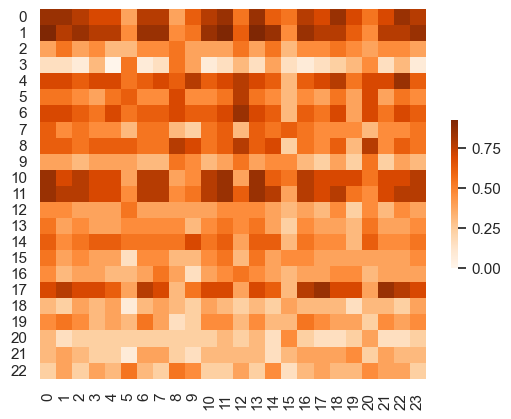

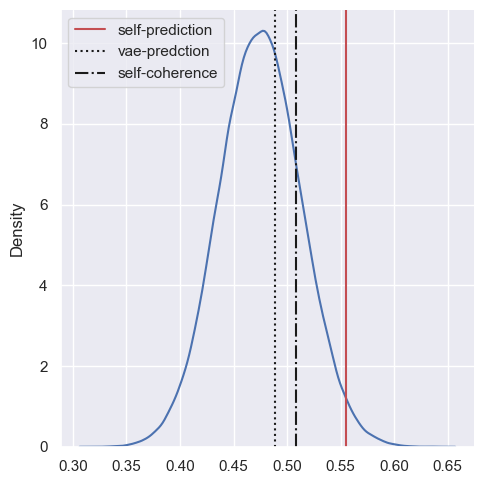

In [4893]:
accuracy_matrix = np.zeros((testset.shape[2], testset.shape[2]))
error_matrix = np.zeros((23, 23))
for i in range(testset.shape[2]):
    for j in range(testset.shape[2]):
        outputs = model(testset_x[:, :, j])
        predict_label = torch.argmin(outputs, axis=1)
        real_label = torch.argmin(testset_y[:, :, i], axis=1)
        accuracy = torch.sum(predict_label == real_label) / len(predict_label)
        error = torch.sum(((testset_y[:, :, i] > 0) * outputs - testset_y[:, :, i])**2)
        accuracy_matrix[i, j] = accuracy.numpy()
        error_matrix[i, j] = error.detach().numpy()

accuracy_model = []
for i in range(testset.shape[2]):
    outputs = model(modelset)
    predict_label = torch.argmin(outputs, axis=1)
    real_label = torch.argmin(testset_y[:, :, i], axis=1)
    accuracy = torch.sum(predict_label == real_label) / len(predict_label)
    # error = torch.sum(((testset_y[:, :, i] > 0) * outputs - testset_y[:, :, i])**2)
    accuracy_model.append([accuracy])
accuracy_matrix = np.c_[accuracy_matrix, np.array(accuracy_model)]

ax = sns.heatmap(accuracy_matrix, 
                 cmap="Oranges", 
                 square=True, cbar_kws={'shrink': 0.4})

random_data = np.r_[accuracy_matrix[:, :-1][~np.eye(23, dtype=bool)].reshape(-1,), accuracy_matrix[:, -1]]

count = 0
for _ in range(100000):
    if np.sum(np.random.choice(random_data, size=testset.shape[2], replace=False)) > np.sum(np.diag(accuracy_matrix[:, :-1])):
        count += 1
print('p-value', count/100000, 'ave_accuracy', np.sum(np.diag(accuracy_matrix[:, :-1]))/testset.shape[2])

count = 0
for _ in range(10000):
    if np.sum(np.random.choice(random_data, size=testset.shape[2], replace=False)) > np.sum(accuracy_model):
        count += 1
print('p-value', count/10000, 'ave_accuracy', np.sum(accuracy_model)/testset.shape[2])

# count = 0
# for _ in range(10000):
#     if np.sum(np.random.choice(error_matrix.flatten(), size=23, replace=False)) < np.sum(np.diag(error_matrix)):
#         count += 1
# print(count/10000)

# stats.ttest_ind(np.diag(accuracy_matrix[:, :-1]), np.array(accuracy_model)[:, 0])

mc_distribution = []
for _ in range(100000):
    mc_distribution.append(np.sum(np.random.choice(random_data, size=23, replace=False))/23)

plt.rc('lines', linewidth=1.5)
# fig, ax = plt.subplots(figsize=(9,7))
sns.displot(data=mc_distribution, kind="kde")
plt.axvline(x=np.sum(np.diag(accuracy_matrix[:, :-1]))/testset.shape[2], linestyle='-', c='r', alpha=1, label='self-prediction') 
# plt.axvline(x=50.72/100, linestyle='-', c='y', alpha=1, label='self-prediction (in repeated trials)')
plt.axvline(x=np.sum(accuracy_model)/testset.shape[2], linestyle='dotted', c='k', alpha=1, label='vae-predction') 
plt.axvline(x=50.84/100, linestyle='dashdot', c='k', alpha=1, label='self-coherence')
plt.legend()

p-value-self 0.14955 ave_accuracy 0.4949832898767098
p-value-model 0.5637 ave_accuracy 0.4548495334127675
p-value-coherence 0.0561


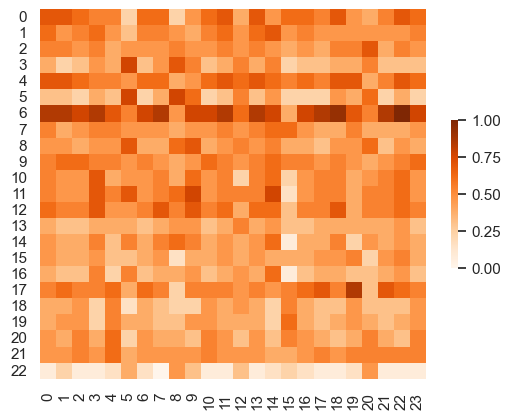

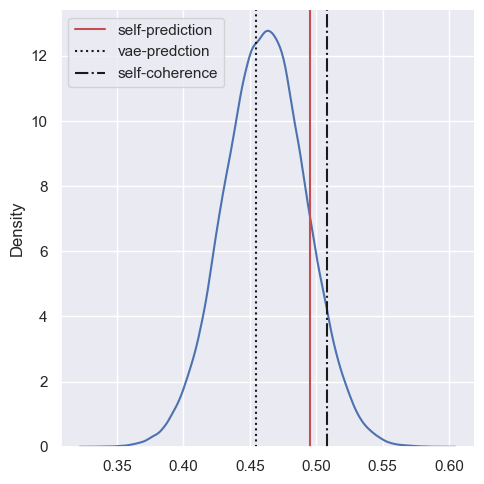

In [4894]:
# the same thing for repeated part
accuracy_matrix = np.zeros((testset.shape[2], testset.shape[2]))
for i in range(testset.shape[2]):
    for j in range(testset.shape[2]):
        outputs = model(testset_x[:, :, j])
        predict_label = torch.argmin(outputs, axis=1)
        real_label = torch.argmin(testset_y_repeat[:, :, i], axis=1)
        accuracy = torch.sum(predict_label == real_label) / len(predict_label)
        accuracy_matrix[i, j] = accuracy.numpy()

accuracy_model = []
for i in range(testset.shape[2]):
    outputs = model(modelset)
    predict_label = torch.argmin(outputs, axis=1)
    real_label = torch.argmin(testset_y_repeat[:, :, i], axis=1)
    accuracy = torch.sum(predict_label == real_label) / len(predict_label)
    # error = torch.sum(((testset_y[:, :, i] > 0) * outputs - testset_y[:, :, i])**2)
    accuracy_model.append([accuracy])
accuracy_matrix = np.c_[accuracy_matrix, np.array(accuracy_model)]

ax = sns.heatmap(accuracy_matrix, 
                 cmap="Oranges", 
                 square=True, cbar_kws={'shrink': 0.4})

random_data = np.r_[accuracy_matrix[:, :-1][~np.eye(23, dtype=bool)].reshape(-1,), accuracy_matrix[:, -1]]

count = 0
for _ in range(100000):
    if np.sum(np.random.choice(random_data, size=testset.shape[2], replace=False)) > np.sum(np.diag(accuracy_matrix[:, :-1])):
        count += 1
print('p-value-self', count/100000, 'ave_accuracy', np.sum(np.diag(accuracy_matrix[:, :-1]))/testset.shape[2])

count = 0
for _ in range(10000):
    if np.sum(np.random.choice(random_data, size=testset.shape[2], replace=False)) > np.sum(accuracy_model):
        count += 1
print('p-value-model', count/10000, 'ave_accuracy', np.sum(accuracy_model)/testset.shape[2])

count = 0
for _ in range(10000):
    if np.mean(np.random.choice(random_data, size=testset.shape[2], replace=False)) > 50.84/100:
        count += 1
print('p-value-coherence', count/10000)

# count = 0
# for _ in range(10000):
#     if np.sum(np.random.choice(error_matrix.flatten(), size=23, replace=False)) < np.sum(np.diag(error_matrix)):
#         count += 1
# print(count/10000)

# stats.ttest_ind(np.diag(accuracy_matrix[:, :-1]), np.array(accuracy_model)[:, 0])

mc_distribution = []
random_data = np.r_[accuracy_matrix[:, :-1][~np.eye(23, dtype=bool)].reshape(-1,), accuracy_matrix[:, -1]]
for _ in range(100000):
    mc_distribution.append(np.sum(np.random.choice(random_data, size=23, replace=False))/23)

plt.rc('lines', linewidth=1.5)
# fig, ax = plt.subplots(figsize=(9,7))
sns.displot(data=mc_distribution, kind="kde")
plt.axvline(x=np.sum(np.diag(accuracy_matrix[:, :-1]))/testset.shape[2], linestyle='-', c='r', alpha=1, label='self-prediction') 
# plt.axvline(x=50.72/100, linestyle='-', c='y', alpha=1, label='self-prediction (in repeated trials)')
plt.axvline(x=np.sum(accuracy_model)/testset.shape[2], linestyle='dotted', c='k', alpha=1, label='vae-predction') 
plt.axvline(x=50.84/100, linestyle='dashdot', c='k', alpha=1, label='self-coherence')
plt.legend()

In [4766]:
# biclustering accuracy_matrix
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np

# Assuming you have your data matrix in a numpy array called 'data_matrix'
# data_matrix should be of shape (n_samples, n_features)

best_score = -1
best_n_clusters_rows = None
best_n_clusters_cols = None

# Iterate over possible numbers of clusters for rows
for n_clusters_rows in range(2, 5):
    # Iterate over possible numbers of clusters for columns
    for n_clusters_cols in range(2, 5):
        # Create a Spectral Biclustering model
        model = SpectralBiclustering(n_clusters=(n_clusters_rows, n_clusters_cols), method='log')

        # Fit the model to the data
        model.fit(accuracy_matrix)

        # Get row and column labels
        row_labels = model.row_labels_
        col_labels = model.column_labels_

        # Compute silhouette score
        silhouette_avg = silhouette_score(accuracy_matrix, row_labels)

        # Compute Calinski-Harabasz score
        ch_score = calinski_harabasz_score(accuracy_matrix, row_labels)

        # Update best_score and best_n_clusters if the current scores are higher
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_n_clusters_rows = n_clusters_rows
            best_n_clusters_cols = n_clusters_cols

print(best_n_clusters_rows, best_n_clusters_cols)
# Create a Spectral Biclustering model with the best number of clusters for rows and columns
best_model = SpectralBiclustering(n_clusters=(best_n_clusters_rows, best_n_clusters_cols), method='log')

# Fit the best model to the data
best_model.fit(accuracy_matrix)

# Get row and column labels from the best model
best_row_labels = best_model.row_labels_
best_col_labels = best_model.column_labels_

# Reorder the data matrix based on the bicluster labels
ordered_data = accuracy_matrix[np.argsort(best_row_labels)]
ordered_data = ordered_data[:, np.argsort(best_col_labels)]

2 2


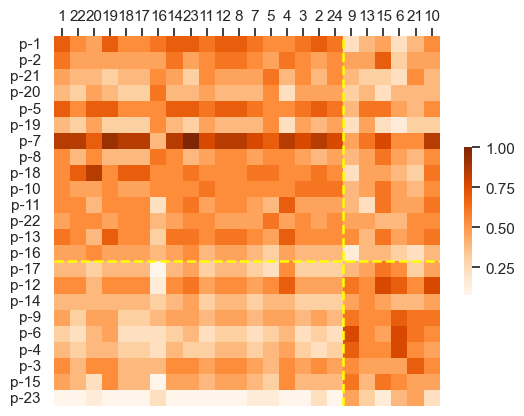

In [4767]:
yticks = [i+0.5 for i in range(len(accuracy_matrix))]
yticklabels = [f'p-{i+1}' for i in np.argsort(best_row_labels)]
xticklabels = [i+1 for i in np.argsort(best_col_labels)]
ax = sns.heatmap(ordered_data, 
                 cmap="Oranges", 
                 square=True, cbar_kws={'shrink': 0.4}, xticklabels=xticklabels, yticklabels=yticklabels)
cols = np.unique(best_col_labels)
rows = np.unique(best_row_labels)
boundry = 0
for i in cols[:-1]:
    boundry += np.sum(best_col_labels == i)
    ax.axvline(x=boundry, color='yellow',linewidth=1.8, linestyle='--')

boundry = 0
for i in rows[:-1]:
    boundry += np.sum(best_row_labels == i)
    ax.axhline(y=boundry, color='yellow',linewidth=1.8, linestyle='--')
    
ax.set_yticks(yticks)
ax.xaxis.tick_top()

In [2289]:
stats.ttest_ind(np.diag(accuracy_matrix[:, :-1]), np.array(accuracy_model)[:, 0])

TtestResult(statistic=1.309238087607606, pvalue=0.19724983686215208, df=44.0)

In [2042]:
stats.ttest_1samp(np.diag(accuracy_matrix[:, :-1]), popmean=0.33)

TtestResult(statistic=6.067926929056669, pvalue=4.160591465723601e-06, df=22)

In [5824]:
# distribution_param  # [0][0].numpy()
happy_means = np.zeros((23, 3))
happy_covs = np.zeros((23, 3, 3))
sad_means = np.zeros((23, 3))
sad_covs = np.zeros((23, 3, 3))
neutral_means = np.zeros((23, 3))
neutral_covs = np.zeros((23, 3, 3))

for i in range(len(distribution_param)):
    if i%3 == 0:
        happy_means[i//3, :] = distribution_param[i][0].numpy()
        happy_covs[i//3, :, :] = distribution_param[i][1].numpy()
    elif i%3 == 1:
        sad_means[i//3, :] = distribution_param[i][0].numpy()
        sad_covs[i//3, :, :] = distribution_param[i][1].numpy()
    elif i%3 == 2:
        neutral_means[i//3, :] = distribution_param[i][0].numpy()
        neutral_covs[i//3, :, :] = distribution_param[i][1].numpy()

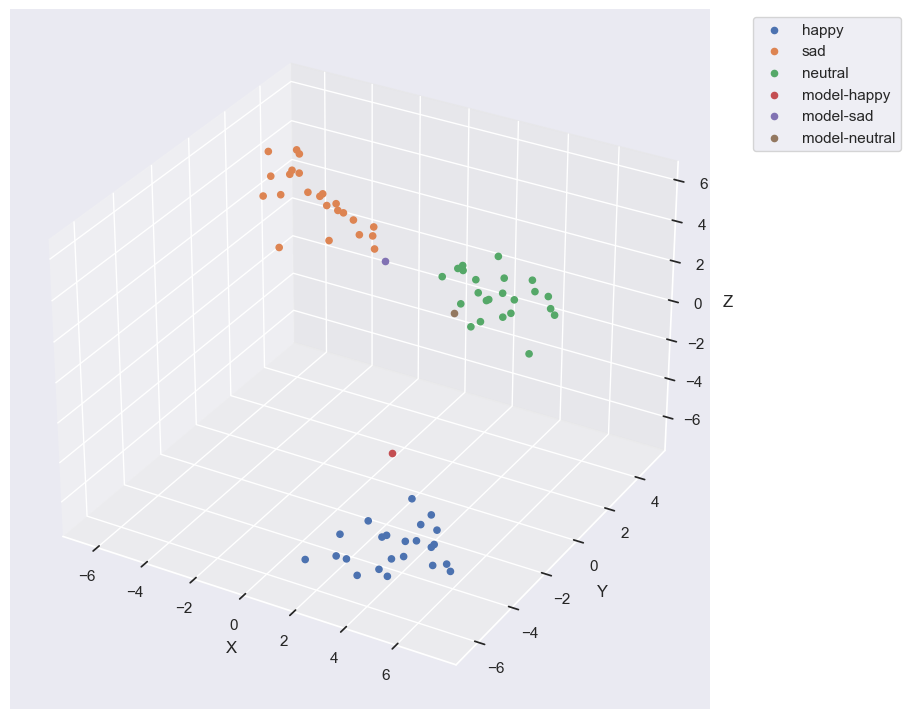

In [5855]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(9,7))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(happy_means[:, 0], happy_means[:, 1], happy_means[:, 2], marker='o', alpha=1, label='happy')
sc = ax.scatter(sad_means[:, 0], sad_means[:, 1], sad_means[:, 2], marker='o', alpha=1, label='sad')
sc = ax.scatter(neutral_means[:, 0], neutral_means[:, 1], neutral_means[:, 2], marker='o', alpha=1, label='neutral')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

sc = ax.scatter(3.0, -3.13, -2.78, marker='o', alpha=1, label='model-happy')
sc = ax.scatter(-0.69, 1.80, 1.78, marker='o', alpha=1, label='model-sad')
sc = ax.scatter(1.70, 2.43, -0.48, marker='o', alpha=1, label='model-neutral')

# legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [5914]:
# distance: kl_divergence or bhattacharyya_distance
similartity_repre = np.zeros_like(acc)
for i in range(23):
    for j in range(23):
        mean_kl = 1*kl_divergence(happy_means[j], happy_covs[j], happy_means[i], happy_covs[i]) + kl_divergence(sad_means[j], sad_covs[j], sad_means[i], sad_covs[i]) + kl_divergence(neutral_means[j], neutral_covs[j], neutral_means[i], neutral_covs[i])
        # mean_kl = custom_distance(happy_means[j], sad_means[j], neutral_means[j], happy_means[i], sad_means[i], neutral_means[i])
        # mean_kl = np.sqrt(np.sum((locate(happy_means[j], happy_covs[j], sad_means[j], sad_covs[j], neutral_means[j], neutral_covs[j]) - locate(happy_means[i], happy_covs[i], sad_means[i], sad_covs[i], neutral_means[i], neutral_covs[i]))**2))
        similartity_repre[i, j] = mean_kl/3
# similartity_repre

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2841
Date:                Thu, 28 Mar 2024   Prob (F-statistic):              0.594
Time:                        03:48:32   Log-Likelihood:                 277.92
No. Observations:                 529   AIC:                            -551.8
Df Residuals:                     527   BIC:                            -543.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4362      0.010     43.387      0.0

<Axes: >

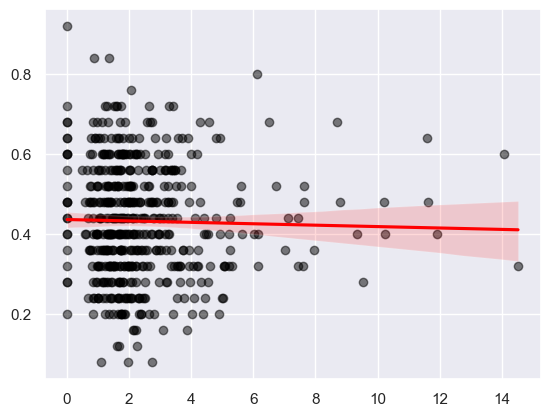

In [5921]:
y = np.array(acc).flatten().reshape(-1, 1)
X = similartity_repre.flatten().reshape(-1, 1)
X = sm.add_constant(X)
linearreg = sm.OLS(y, X).fit()
print(linearreg.summary())

sns.regplot(x = similartity_repre.flatten(), y = np.array(acc).flatten(), 
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

In [5846]:
# linear prediction using presentation in VA space
happy_va_mean = np.load('./secondary-data/happy_va_mean.npy')
happy_va_cov = np.load('./secondary-data/happy_va_cov.npy')
sad_va_mean = np.load('./secondary-data/sad_va_mean.npy')
sad_va_cov = np.load('./secondary-data/sad_va_cov.npy')
neutral_va_mean = np.load('./secondary-data/neutral_va_mean.npy')
neutral_va_cov = np.load('./secondary-data/neutral_va_cov.npy')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.431
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.232
Time:                        02:19:29   Log-Likelihood:                 245.82
No. Observations:                 529   AIC:                            -487.6
Df Residuals:                     527   BIC:                            -479.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4769      0.012     39.017      0.0

<Axes: >

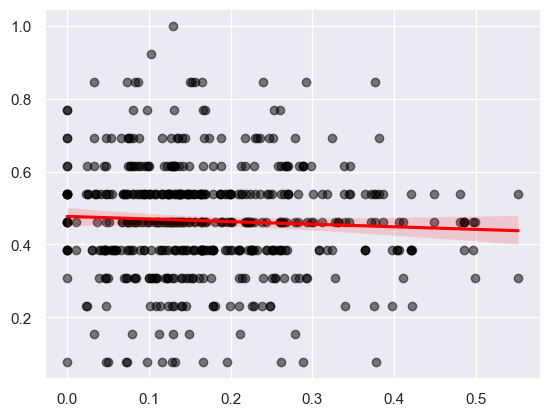

In [4853]:
similartity_repre = np.zeros_like(accuracy_matrix[:, :-1])
for i in range(23):
    for j in range(23):
        # mean_kl = bhattacharyya_distance(happy_means[j], happy_covs[j], happy_means[i], happy_covs[i]) + bhattacharyya_distance(sad_means[j], sad_covs[j], sad_means[i], sad_covs[i]) + bhattacharyya_distance(neutral_means[j], neutral_covs[j], neutral_means[i], neutral_covs[i])
        # mean_kl = custom_distance(happy_va_mean[j], sad_va_mean[j], neutral_va_mean[j], happy_va_mean[i], sad_va_mean[i], neutral_va_mean[i])
        mean_kl = np.sqrt(np.sum((locate(happy_va_mean[j], happy_va_cov[j], sad_va_mean[j], sad_va_cov[j], neutral_va_mean[j], neutral_va_cov[j]) - locate(happy_va_mean[i], happy_va_cov[i], sad_va_mean[i], sad_va_cov[i], neutral_va_mean[i], neutral_va_cov[i]))**2))
        similartity_repre[i, j] = mean_kl
# similartity_repre
y = accuracy_matrix[:, :-1].flatten().reshape(-1, 1)
X = similartity_repre.flatten().reshape(-1, 1)
X = sm.add_constant(X)
linearreg = sm.OLS(y, X).fit()
print(linearreg.summary())

sns.regplot(x = similartity_repre.flatten(), y = accuracy_matrix[:, :-1].flatten(), 
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red"})

## inter-consistency

In [124]:
individual_train_x = indvidual_trainset[:, -3:, :]
individual_train_y = indvidual_trainset[:, :2, :]
indvidual_trainset.shape

(25, 5, 23)

In [125]:
testset_y[22, :, 0]

array([ 0., 35.])

In [126]:
inter_consistency_1 = np.zeros((23, 23))
inter_consistency_2 = np.zeros((23, 23))
inter_consistency_3 = np.zeros((23, 23))
for i in range(23):
    for j in range(23):
        inter_consistency_1[i, j] = np.mean(individual_train_y[:, 0, i] == individual_train_y[:, 0, j])
        # inter_consistency_2[i, j] = np.mean(np.argmin(testset_y[:, :, i], axis=1) == np.argmin(testset_y[:, :, j], axis=1))
        # inter_consistency_3[i, j] = np.mean(np.argmin(testset_y_repeat[:, :, i], axis=1) == np.argmin(testset_y_repeat[:, :, j], axis=1))
        inter_consistency_2[i, j] = np.mean(testset_y[:, 0, i] == testset_y[:, 0, j])
        inter_consistency_3[i, j] = np.mean(testset_y_repeat[:, 0, i] == testset_y_repeat[:, 0, j])

In [127]:
print(np.mean(inter_consistency_1[np.triu_indices(23, 1)]), 
      1.96*np.std(inter_consistency_1[np.triu_indices(23, 1)]) / np.sqrt(len(inter_consistency_1[np.triu_indices(23, 1)])))

0.4211857707509882 0.019650068660876985


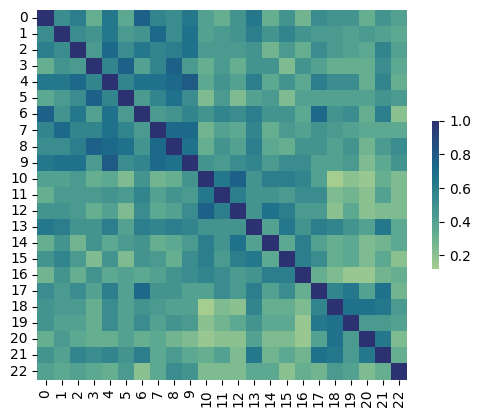

In [128]:
ax = sns.heatmap(inter_consistency_3, 
     cmap="crest", 
     square=True, cbar_kws={'shrink': 0.4})

[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0, '1.0')]

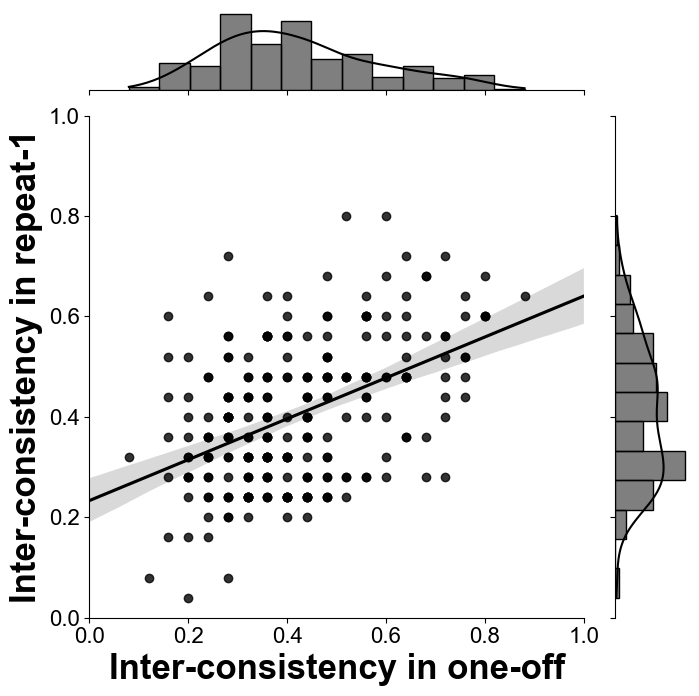

In [132]:
h = sns.jointplot(x=inter_consistency_1[np.triu_indices(23, 1)], y=inter_consistency_2[np.triu_indices(23, 1)], 
                  kind="reg", truncate=False, 
                  xlim=(0, 1), ylim=(0, 1),
                  color="k", height=7)

# ax.legend(prop={'family':'Arial', 'size':16}, fancybox=True, ncol=1, loc='upper left')
h.set_axis_labels('Inter-consistency in one-off', 'Inter-consistency in repeat-1', fontdict={'fontsize': 25, 'family':'Arial', 'weight':'bold'})
h.figure.tight_layout() 

h.ax_joint.xaxis.set_ticks(np.arange(0, 1.1, 0.2))
h.ax_joint.set_xticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={'fontsize': 16, 'family':'Arial'})

# h.ax_joint.set_title('Distribution of inter-consistency (one-off and repeat-1)', fontdict={'fontsize': 16, 'family':'Arial'})

h.ax_joint.yaxis.set_ticks(np.arange(0, 1.1, 0.2))
h.ax_joint.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontdict={'fontsize': 16, 'family':'Arial'})

## few-parameter modeling

In [49]:
individual_train_x = indvidual_trainset[:, -3:, :]
individual_train_y = indvidual_trainset[:, :2, :]
indvidual_trainset.shape
distribution_param = np.load('secondary-data/parameter_gaussian.npy')  # all means

In [18]:
# parameter searching with only mean known
# set seed
cross_predict_all = []
cross_predict_likelihood = []
cross_predict_prior = []
self_predict = []
model_predict = []
resnet_predict = []
all_params = []
locs_train = probe_rec_train['loc'].tolist()
for ite in tqdm(range(100)):
    priors = []
    vars = []
    predicts = []
    performance = []
    corrs = []
    for sub in range(23):
        best_performance = 0
        for _ in range(1000):
            params_prior = [np.random.uniform(0, 50), np.random.uniform(-5, 10)]  # 0 50 -5 10
            params_var = [np.random.uniform(0, 10), np.random.uniform(0, 10), np.random.uniform(0, 10)]

            # representation_happy = Normal(np.array(distribution_param[sub*3]), np.eye(3)*params_var[0])
            representation_happy = multivariate_normal(distribution_param[sub*3], np.eye(3)*params_var[0])
            # representation_sad = Normal(np.array(distribution_param[sub*3+1]), np.eye(3)*params_var[1])
            representation_sad = multivariate_normal(distribution_param[sub*3+1], np.eye(3)*params_var[1])
            # representation_neutral = Normal(np.array(distribution_param[sub*3+2]), np.eye(3)*params_var[2])
            representation_neutral = multivariate_normal(distribution_param[sub*3+2], np.eye(3)*params_var[2])

            likelihood_happy = representation_happy.logpdf(locs_train).reshape(-1, 1)
            likelihood_sad = representation_sad.logpdf(locs_train).reshape(-1, 1)
            likelihood_neutral = representation_neutral.logpdf(locs_train).reshape(-1, 1)
            
            output = np.c_[likelihood_happy - params_prior[0], likelihood_sad - params_prior[1], likelihood_neutral]
            confidence = individual_train_y[:, 1, sub] #.reshape(25, 1)
            predict = np.argmin(output, axis=1)
            accuracy = np.mean(predict == individual_train_y[:, 0, sub])
            confidence_corr = np.corrcoef(confidence, np.sort(output, axis=1)[:, 1]-np.min(output, axis=1))[0, 1]
            target_func = accuracy * 0.8 + confidence_corr * 0.2
            
            if target_func > best_performance:
                best_performance = target_func
                best_prior = params_prior
                best_var = [representation_happy, representation_sad, representation_neutral]  # params_var
                best_predict = predict
                best_corr = confidence_corr
            # elif accuracy > best_acc-0.05 and confidence_corr > best_corr: # give some tolerance to accuracy to trade off the confidence
            #     best_acc = accuracy
            #     best_prior = params_prior
            #     best_var = params_var
            #     best_predict = predict
            #     best_corr = confidence_corr
                
        priors.append(best_prior)
        vars.append(best_var)
        predicts.append(best_predict)
        performance.append(best_performance)
        corrs.append(best_corr)
            
    # print("After searching, the best accuracy in trainset is:", np.mean(accuracies))
    
    cross_all = np.zeros((23, 23))
    cross_likelihood = np.zeros((23, 23))
    cross_prior = np.zeros((23, 23))
    model_likelihood_repeat = np.zeros((23, ))
    cross_all_repeat = np.zeros((23, 23))
    cross_likelihood_repeat = np.zeros((23, 23))
    cross_prior_repeat = np.zeros((23, 23))
    model_likelihood = np.zeros((23, ))
    locs = probe_rec_test['loc'].tolist()
    for i in range(23):
        label = testset_y[:, 0, i]
        label_repeat = testset_y_repeat[:, 0, i]
        
        happy_target = vars[i][0].logpdf(locs).reshape(-1, 1)
        sad_target = vars[i][1].logpdf(locs).reshape(-1, 1)
        neutral_target = vars[i][2].logpdf(locs).reshape(-1, 1)
        
        for j in range(23):

            happy_predictor = vars[j][0].logpdf(locs).reshape(-1, 1)
            sad_predictor = vars[j][1].logpdf(locs).reshape(-1, 1)
            neutral_predictor = vars[j][2].logpdf(locs).reshape(-1, 1)
            
            predict_a = np.argmin(np.c_[
                                  happy_predictor - priors[j][0],
                                  sad_predictor - priors[j][1], 
                                  neutral_predictor
                                  ], axis=1)
            predict_l = np.argmin(np.c_[
                                  happy_predictor - priors[i][0],
                                  sad_predictor - priors[i][1], 
                                  neutral_predictor
                                  ], axis=1)
            predict_p = np.argmin(np.c_[
                                  happy_target - priors[j][0],
                                  sad_target - priors[j][1], 
                                  neutral_target
                                  ], axis=1)
            cross_all[i, j] = np.mean(predict_a == label)
            cross_likelihood[i, j] = np.mean(predict_l == label)
            cross_prior[i, j] = np.mean(predict_p == label)
            cross_all_repeat[i, j] = np.mean(predict_a == label_repeat)
            cross_likelihood_repeat[i, j] = np.mean(predict_l == label_repeat)
            cross_prior_repeat[i, j] = np.mean(predict_p == label_repeat)
        predict_m = np.argmin(np.c_[
                              modelset[:, 0] - priors[i][0],
                              modelset[:, 1] - priors[i][1], 
                              modelset[:, 2]
                              ], axis=1)
        model_likelihood[i] = np.mean(predict_m == label)
        model_likelihood_repeat[i] = np.mean(predict_m == label_repeat)

    self_coherence = np.mean(repeat_accuracy_fer)
    resnet_predict = (np.mean(resnet_fer_repeat)+np.mean(resnet_fer))/2
    
    self_acc = (np.mean(np.diagonal(cross_likelihood)) + np.mean(np.diagonal(cross_likelihood_repeat)))/2
    self_predict.append(self_acc)
    # self_prediction_accuracy.append(self_acc)
    
    model_acc = (np.mean(model_likelihood) + np.mean(model_likelihood_repeat))/2
    model_predict.append(model_acc)
    
    cross_predict_all.append((np.mean(cross_all[~np.eye(23, dtype=bool)].reshape(-1,))+np.mean(cross_all_repeat[~np.eye(23, dtype=bool)].reshape(-1,)))/2)
    # cross_predict_likelihood.append(np.mean(np.random.choice(cross_likelihood[~np.eye(23, dtype=bool)].reshape(-1,), size=23, replace=False)))
    cross_predict_likelihood.append((np.mean(cross_likelihood[~np.eye(23, dtype=bool)].reshape(-1,))+np.mean(cross_likelihood_repeat[~np.eye(23, dtype=bool)].reshape(-1,)))/2)
    cross_predict_prior.append((np.mean(cross_prior[~np.eye(23, dtype=bool)].reshape(-1,))+np.mean(cross_prior_repeat[~np.eye(23, dtype=bool)].reshape(-1,)))/2)
    # self_predict.append(-self_acc+np.mean(repeat_accuracy_fer))
    
print(np.mean(self_predict), np.std(self_predict)/10)

100%|█████████████████████████████████████████████████████████████| 100/100 [08:44<00:00,  5.24s/it]

0.4180434782608695 0.0007956759321708287


In [50]:
# parameter searching
# set seed
self_prediction_accuracy = []

cross_predict_all = []
cross_predict_likelihood = []
cross_predict_prior = []
self_predict = []
model_predict = []
all_params = []
for ite in tqdm(range(100)):
    params = []
    predicts = []
    performance = []
    corrs = []
    for sub in range(23):
        # best_acc = 0
        # best_corr = 0
        best_performance = 0
        for _ in range(1000):
            params_prior = [np.random.uniform(0, 50), np.random.uniform(-5, 10)]  # 0 50 -5 10
            
            output = np.c_[individual_train_x[:, 0, sub] - params_prior[0], individual_train_x[:, 1, sub] - params_prior[1], individual_train_x[:, 2, sub]]
            confidence = individual_train_y[:, 1, sub] #.reshape(25, 1)
            predict = np.argmin(output, axis=1)
            accuracy = np.mean(predict == individual_train_y[:, 0, sub])
            confidence_corr = np.corrcoef(confidence, np.sort(output, axis=1)[:, 1]-np.min(output, axis=1))[0, 1]
            target_func = accuracy * 0.8 + confidence_corr * 0.2
            
            if target_func > best_performance:
                best_performance = target_func
                best_params = params_prior
                best_predict = predict
                best_corr = confidence_corr
            # elif accuracy > best_acc-0.05 and confidence_corr > best_corr: # give some tolerance to accuracy to trade off the confidence
            #     best_acc = accuracy
            #     best_params = params_prior
            #     best_predict = predict
            #     best_corr = confidence_corr
                
        params.append(best_params)
        predicts.append(best_predict)
        performance.append(best_performance)
        corrs.append(best_corr)
            
    # print("After searching, the best accuracy in trainset is:", np.mean(accuracies))
    all_params.append(params)
    
    cross_all = np.zeros((23, 23))
    cross_likelihood = np.zeros((23, 23))
    cross_prior = np.zeros((23, 23))
    model_likelihood_repeat = np.zeros((23, ))
    cross_all_repeat = np.zeros((23, 23))
    cross_likelihood_repeat = np.zeros((23, 23))
    cross_prior_repeat = np.zeros((23, 23))
    model_likelihood = np.zeros((23, ))
    for i in range(23):
        label = testset_y[:, 0, i]
        label_repeat = testset_y_repeat[:, 0, i]
        for j in range(23):
            predict_a = np.argmin(np.c_[
                                  testset_x[:, 0, j] - params[j][0],
                                  testset_x[:, 1, j] - params[j][1], 
                                  testset_x[:, 2, j]
                                  ], axis=1)
            predict_l = np.argmin(np.c_[
                                  testset_x[:, 0, j] - params[i][0],
                                  testset_x[:, 1, j] - params[i][1], 
                                  testset_x[:, 2, j]
                                  ], axis=1)
            predict_p = np.argmin(np.c_[
                                  testset_x[:, 0, i] - params[j][0],
                                  testset_x[:, 1, i] - params[j][1], 
                                  testset_x[:, 2, i]
                                  ], axis=1)
            cross_all[i, j] = np.mean(predict_a == label)
            cross_likelihood[i, j] = np.mean(predict_l == label)
            cross_prior[i, j] = np.mean(predict_p == label)
            cross_all_repeat[i, j] = np.mean(predict_a == label_repeat)
            cross_likelihood_repeat[i, j] = np.mean(predict_l == label_repeat)
            cross_prior_repeat[i, j] = np.mean(predict_p == label_repeat)
        predict_m = np.argmin(np.c_[
                              modelset[:, 0] - params[i][0],
                              modelset[:, 1] - params[i][1], 
                              modelset[:, 2]
                              ], axis=1)
        model_likelihood[i] = np.mean(predict_m == label)
        model_likelihood_repeat[i] = np.mean(predict_m == label_repeat)

    self_coherence = np.mean(repeat_accuracy_rec)
    resnet_predict = (np.mean(resnet_rec_repeat)+np.mean(resnet_rec))/2
    
    self_acc = (np.mean(np.diagonal(cross_likelihood)) + np.mean(np.diagonal(cross_likelihood_repeat)))/2
    self_predict.append(self_acc)
    # self_prediction_accuracy.append(self_acc)
    
    model_acc = (np.mean(model_likelihood) + np.mean(model_likelihood_repeat))/2
    model_predict.append(model_acc)
    
    cross_predict_all.append((np.mean(cross_all[~np.eye(23, dtype=bool)].reshape(-1,))+np.mean(cross_all_repeat[~np.eye(23, dtype=bool)].reshape(-1,)))/2)
    # cross_predict_likelihood.append(np.mean(np.random.choice(cross_likelihood[~np.eye(23, dtype=bool)].reshape(-1,), size=23, replace=False)))
    cross_predict_likelihood.append((np.mean(cross_likelihood[~np.eye(23, dtype=bool)].reshape(-1,))+np.mean(cross_likelihood_repeat[~np.eye(23, dtype=bool)].reshape(-1,)))/2)
    cross_predict_prior.append((np.mean(cross_prior[~np.eye(23, dtype=bool)].reshape(-1,))+np.mean(cross_prior_repeat[~np.eye(23, dtype=bool)].reshape(-1,)))/2)
    # self_predict.append(-self_acc+np.mean(repeat_accuracy_fer))
    
print(np.mean(self_predict), np.std(self_predict)/10)

100%|███████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]

0.43836521739130424 0.0007279751548555459


In [47]:
# all priors estimated
priors_rec = np.array(all_params)

In [63]:
densities = np.power(10, np.c_[priors_rec.mean(axis=0), np.ones((23, 1))])
probabilities = densities / densities.sum(axis=1, keepdims=True)
probabilities

array([[1.00000000e+00, 4.97566826e-18, 1.82129759e-17],
       [9.99999883e-01, 1.17020507e-07, 1.75111863e-14],
       [9.99837907e-01, 1.13986358e-04, 4.81069455e-05],
       [9.99926418e-01, 7.35819030e-05, 1.85813186e-13],
       [1.00000000e+00, 5.90152662e-22, 2.66587353e-17],
       [1.00000000e+00, 3.19081272e-30, 6.56961544e-39],
       [9.96504465e-01, 5.40999728e-07, 3.49499393e-03],
       [1.00000000e+00, 1.65538446e-21, 4.31158776e-21],
       [1.00000000e+00, 7.99057186e-24, 2.02727361e-31],
       [1.00000000e+00, 4.00118205e-33, 2.87563501e-31],
       [1.00000000e+00, 4.28624384e-14, 2.32840711e-12],
       [6.24163902e-01, 6.78562290e-05, 3.75768242e-01],
       [1.00000000e+00, 1.26610107e-18, 2.50319421e-19],
       [9.99992426e-01, 7.02700475e-06, 5.46572110e-07],
       [3.56443314e-01, 3.43349956e-03, 6.40123187e-01],
       [1.00000000e+00, 3.13523056e-20, 1.05902062e-22],
       [6.30765490e-01, 3.69234508e-01, 1.12839641e-09],
       [7.73648068e-01, 1.48411

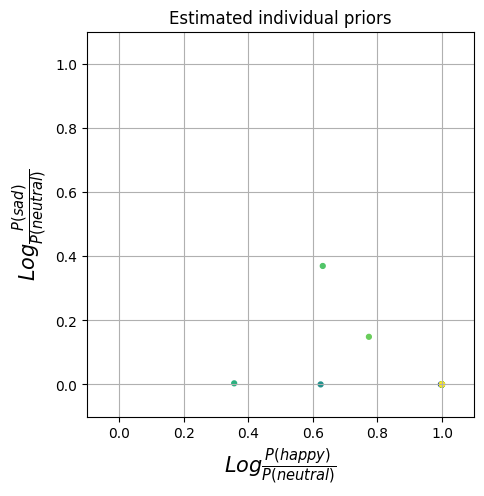

In [71]:
fig, ax = plt.subplots(figsize=(5, 5))

colors = np.arange(23)/100

ax.scatter(probabilities[:, 0], probabilities[:, 1], c=colors, s=12)
ax.set_xlabel(r'$Log \frac{P(happy)}{P(neutral)}$', fontsize=15)
ax.set_ylabel(r'$Log \frac{P(sad)}{P(neutral)}$', fontsize=15)
ax.set_title('Estimated individual priors')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

In [19]:
self_coherence

0.6365217391304349

In [111]:
stats.ttest_1samp(all_performance[all_performance['type']=='mvt']['Self-prediction'].values, popmean=self_coherence)

TtestResult(statistic=-11.53936208055654, pvalue=5.250903283190807e-29, df=999)

In [14]:
all_acc = np.stack([self_predict, cross_predict_all, cross_predict_likelihood, cross_predict_prior, model_predict])
data = pd.DataFrame(all_acc.T, columns=['Self-prediction', 
                                        'Cross-prediction(all)', 
                                        'Cross-prediction(l)', 
                                        'Cross-prediction(p)', 
                                        'VAE-prediction'])
data['type'] = ['mean_variance' for _ in range(len(data))]

In [20]:
all_acc = np.stack([self_predict, cross_predict_all, cross_predict_likelihood, cross_predict_prior, model_predict])
variance_data = pd.DataFrame(all_acc.T, columns=['Self-prediction', 
                                        'Cross-prediction(all)', 
                                        'Cross-prediction(l)', 
                                        'Cross-prediction(p)', 
                                        'VAE-prediction'])
variance_data['type'] = ['mean' for _ in range(len(variance_data))]

In [26]:
all_acc = np.stack([self_predict, cross_predict_all, cross_predict_likelihood, cross_predict_prior, model_predict])
mvtdata = pd.DataFrame(all_acc.T, columns=['Self-prediction', 
                                        'Cross-prediction(all)', 
                                        'Cross-prediction(l)', 
                                        'Cross-prediction(p)', 
                                        'VAE-prediction'])
mvtdata['type'] = ['mvt' for _ in range(len(mvtdata))]

In [28]:
all_data = pd.concat([data, variance_data, mvtdata], axis=0, ignore_index=True, sort=False)
all_data

,Self-prediction,Cross-prediction(all),Cross-prediction(l),Cross-prediction(p),VAE-prediction,type
0,0.437391,0.375929,0.406957,0.352530,0.346087,mean_variance
1,0.437391,0.372648,0.401739,0.349447,0.343478,mean_variance
2,0.418261,0.372964,0.397312,0.348103,0.335652,mean_variance
3,0.434783,0.380237,0.402332,0.351067,0.338261,mean_variance
4,0.437391,0.378300,0.398972,0.347312,0.337391,mean_variance
...,...,...,...,...,...,...
2095,0.429565,0.368063,0.422372,0.356640,0.383478,mvt
2096,0.435652,0.371858,0.421028,0.358933,0.386957,mvt
2097,0.434783,0.369012,0.424901,0.359091,0.378261,mvt
2098,0.434783,0.370237,0.419881,0.352213,0.373913,mvt


In [29]:
all_data.to_pickle('secondary-data/all_performance_fer2013.pkl')
# all_performance = pd.read_pickle('secondary-data/all_performance_here.pkl')

In [17]:
data

,Self-prediction,Cross-prediction(all),Cross-prediction(l),Cross-prediction(p),VAE-prediction,type
0,0.493043,0.431858,0.458024,0.372806,0.366957,mean_variance
1,0.496522,0.437273,0.456008,0.372055,0.356522,mean_variance
2,0.502609,0.435020,0.453597,0.373399,0.371304,mean_variance
3,0.504348,0.434625,0.457510,0.370514,0.376522,mean_variance
4,0.490435,0.434862,0.451700,0.371542,0.377391,mean_variance
...,...,...,...,...,...,...
1995,0.392174,0.287984,0.321304,0.361107,0.338261,mean
1996,0.388696,0.282134,0.308024,0.379723,0.311304,mean
1997,0.397391,0.290277,0.318893,0.355494,0.318261,mean
1998,0.387826,0.282372,0.306601,0.356245,0.361739,mean


In [29]:
data[data['type']=='mean']['Self-prediction'].mean()

0.4180434782608695

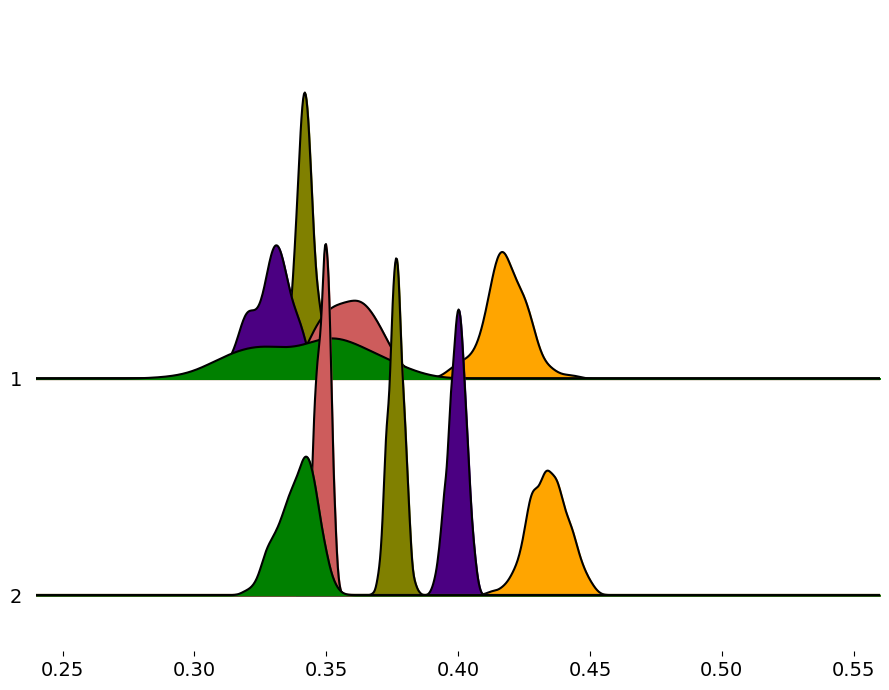

In [24]:
# visualization
data = pd.read_pickle('secondary-data/all_performance_fer2013.pkl')
# data = pd.read_pickle('secondary-data/all_performance_here.pkl')
data = data[data['type']!='mvt']
# data.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)

# fig, ax = plt.subplots(figsize=(7,7))
# ax = sns.displot(data=data, kind="kde", fill=True, rug=True, 
#                  palette=sns.color_palette('bright')[:5], height=7, aspect=1.7, legend=True)

# # ax.legend(prop={'family':'Arial', 'size':16}, fancybox=True, ncol=1)
# ax.set_axis_labels("Accuracy", "Density", fontdict={'fontsize': 20, 'family':'Arial'})
# # plt.title('Distributon of differences between self-prediction and other kinds of prediction', fontdict={'fontsize': 16, 'family':'Arial'})
# plt.xlim(0.25, 0.55)
# plt.ylim(0, 30)  # 40
# ax.set(xticks=[0.30, resnet_predict, 0.4, 0.5, 0.6, self_coherence], yticks=[0, 30])
# ax.set_xticklabels(["30%", f"ResNet-18's\nprediction ({np.round(resnet_predict*100, 1)}%)", " ", "50%", "", f"Self-coherence ({self_coherence*100}%)"], fontdict={'fontsize': 16, 'family':'Arial'})
# ax.set_yticklabels([0, 30], fontdict={'fontsize': 16, 'family':'Arial'})
# # ax.add_legend(prop={'family':'Arial', 'size':16})
# ax.refline(x=self_coherence, linestyle='--', c='k', alpha=0.8, linewidth=2)
# ax.refline(x=resnet_predict, linestyle='--', c='k', alpha=0.8, linewidth=2)
# # plt.setp(ax._legend.get_title(), fontsize=32)
# sns.move_legend(ax, "upper right", bbox_to_anchor = (0.7, 0.96), fontsize=19, frameon = True)

fig, ax = joypy.joyplot(data, by='type', figsize=(9,7),
                        linecolor="black", 
                        legend=False, fade=False, 
                        overlap=3, 
                        color=["#FFA500", "#808000", "#4B0082", "#CD5C5C", "#008000"], 
                        range_style='all', 
                        x_range=(0.24, 0.56), 
                        yrot=0, xrot=0, 
                        grid=False, background = "white", 
                        xlabelsize=14, ylabelsize=14, labels=['1', '2'], xlabels=True)

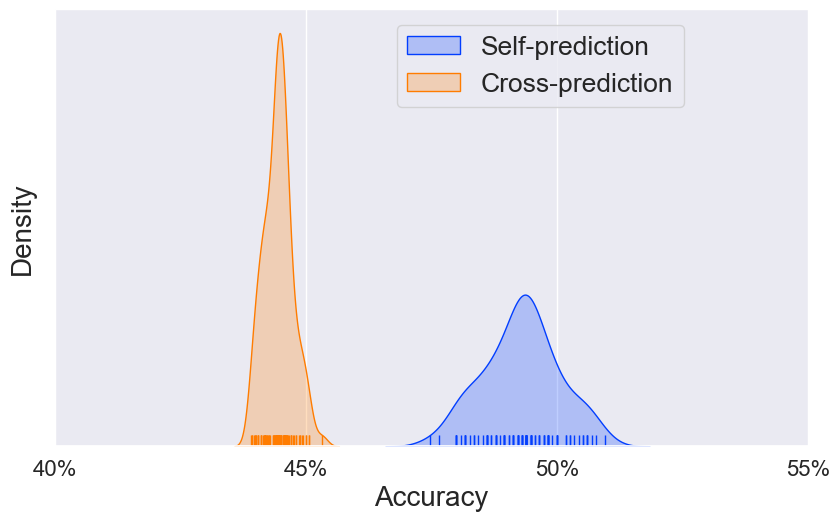

In [26]:
# visualization
all_acc = np.stack([self_predict, cross_predict_likelihood])
data = pd.DataFrame(all_acc.T, columns=['Self-prediction', 
                                        # 'Cross-prediction(all)', 
                                        'Cross-prediction', 
                                        # 'Cross-prediction(p)', 
                                        # 'VAE-prediction',
                                       ])

# fig, ax = plt.subplots(figsize=(7,7))
ax = sns.displot(data=data, kind="kde", fill=True, rug=True, 
                 palette=sns.color_palette('bright')[:2], height=5, aspect=1.7, legend=True)

# ax.legend(prop={'family':'Arial', 'size':16}, fancybox=True, ncol=1)
ax.set_axis_labels("Accuracy", "Density", fontdict={'fontsize': 20, 'family':'Arial'})
# plt.title('Distributon of differences between self-prediction and other kinds of prediction', fontdict={'fontsize': 16, 'family':'Arial'})
plt.xlim(0.40, 0.55)
plt.ylim(0, 80)  # 40
ax.set(xticks=[0.4, 0.45, 0.5, 0.55], yticks=[0, 80])
ax.set_xticklabels(["40%", "45%", "50%", "55%"], fontdict={'fontsize': 16, 'family':'Arial'})
ax.set_yticklabels(["", ""], fontdict={'fontsize': 16, 'family':'Arial'})
# plt.setp(ax._legend.get_title(), fontsize=32)
sns.move_legend(ax, "upper right", bbox_to_anchor = (0.7, 0.96), fontsize=19, frameon = True)

(0.0, 0.4)

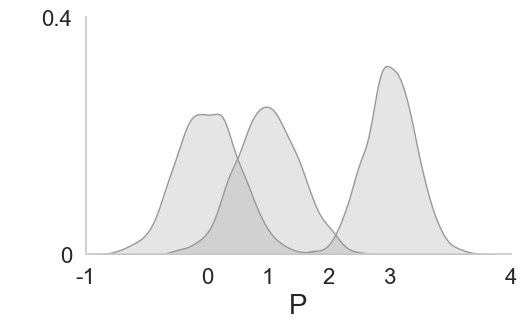

In [235]:
# abitrary distributions of representation
# sns.set_style("whitegrid", {'axes.grid' : False})
happy = np.random.normal(0, 0.5, 1000)
sad = np.random.normal(1, 0.5, 1000)
neutral = np.random.normal(3, 0.41, 1000)
all_sample = np.stack([happy, sad, neutral])
data = pd.DataFrame(all_sample.T, columns=['happy', 
                                        'sad', 
                                        'neutral'])

# fig, ax = plt.subplots(figsize=(7,7))
ax = sns.displot(data=data, kind="kde", fill=True, 
                 palette=sns.color_palette(["#999999", "#999999", "#999999"]), height=3, aspect=1.75, legend=False)

# ax.legend(prop={'family':'Arial', 'size':16}, fancybox=True, ncol=1)
ax.set_axis_labels("P", " ", fontdict={'fontsize': 20, 'family':'Arial'})
# plt.title('Distributon of differences between self-prediction and other kinds of prediction', fontdict={'fontsize': 16, 'family':'Arial'})
plt.xlim(-0.2, 0.3)
ax.set(xticks=[-2, 0, 1, 2, 3, 5], yticks=[0, 0.4])
ax.set_xticklabels([-1, 0, 1, 2, 3, 4], fontdict={'fontsize': 16, 'family':'Arial'})
ax.set_yticklabels([0, 0.4], fontdict={'fontsize': 16, 'family':'Arial'})
plt.ylim(0, 0.4)

In [182]:
stats.ttest_1samp(cross_predict_likelihood, 0)

TtestResult(statistic=-1.5047679796563669, pvalue=0.1355675360575093, df=99)

0.1890284671995951


Text(0.5, 1.0, 'priors after searching')

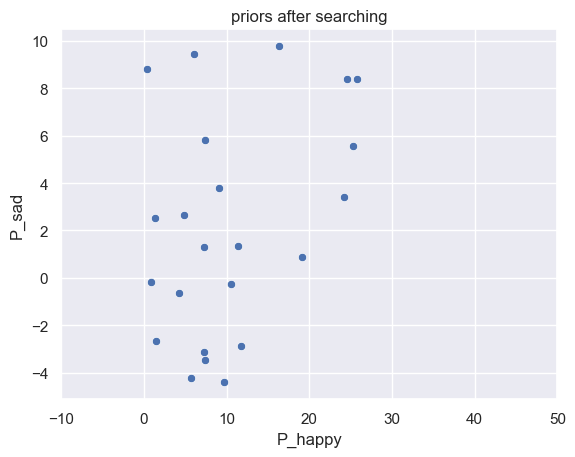

In [34]:
# stats.ttest_rel(cross_predict_likelihood, self_predict)
print(np.mean(corrs))
# params
# params = np.load('saved_Phappy_Psad_normal_1.npy')
sns.scatterplot(x=np.array(params)[:, 0], y=np.array(params)[:, 1])
plt.xlim(-10, 50)
plt.xlabel('P_happy')
plt.ylabel('P_sad')
plt.title("priors after searching")
# np.save('saved_Phappy_Psad.npy', params)

In [188]:
confusion_matrix = np.zeros((3, 3))
for i in range(23):
    predict = np.argmin(np.c_[testset_x[:, 0, i] - params[i][0], testset_x[:, 1, i] - params[i][1], testset_x[:, 2, i]], axis=1)
    label = testset_y_repeat[:, 0, i]  # testset_y_repeat
    for j in range(len(label)):
        confusion_matrix[int(label[j]), predict[j]] += 1
print(confusion_matrix)

confusion_matrix = np.zeros((3, 3))
for i in range(23):
    label = testset_y[:, 0, i]
    predict = testset_y_repeat[:, 0, i]  # testset_y_repeat
    for j in range(len(label)):
        confusion_matrix[int(label[j]), int(predict[j])] += 1
print(confusion_matrix)

[[ 69.  30.  11.]
 [101.  94.  25.]
 [112.  83.  50.]]
[[ 68.  21.  34.]
 [ 18. 143.  56.]
 [ 24.  56. 155.]]


In [127]:
output = np.c_[testset_x[:, 0, predictor_l] - params[predictor_p][0], testset_x[:, 1, predictor_l] - params[predictor_p][1], testset_x[:, 2, predictor_l]]
confidence = np.sort(output, axis=1)[:, 1]-np.min(output, axis=1)
confidence.shape

(25,)

In [152]:
output[np.arange(len(output)), label.astype(int)]

array([11.772653  ,  5.27807684,  8.51883163,  7.78566237,  8.50930538,
        8.09721508,  9.53348923,  5.82605429,  8.24974918, 10.60682525,
        7.77899208,  6.20430632,  5.41894197,  4.8976469 ,  7.40900135,
        8.57748832,  6.91878643, 13.98783941,  9.90997887,  4.18409224,
       14.00640525, 27.91744299, 11.38739462, 13.10063114,  7.32366504])

In [134]:
pred_mode = "all"  # "all" or "likelihood" or "prior"
params = np.mean(all_params, axis=0)
acc = np.zeros((23, 23))
confidence = []
for i in range(23):
    for j in range(23):
        if pred_mode == "all":
            predictor_l = i
            predictor_p = i
        elif pred_mode == "likelihood":
            predictor_l = i
            predictor_p = j
        else:
            predictor_l = j
            predictor_p = i

        output = np.c_[testset_x[:, 0, predictor_l] - params[predictor_p][0], testset_x[:, 1, predictor_l] - params[predictor_p][1], testset_x[:, 2, predictor_l]]
        predict = np.argmin(output, axis=1)
        label = testset_y[:, 0, j]
        accuracy = np.mean(predict == label)
        acc[i, j] = accuracy
        
        if i == j:
            c = np.sort(output, axis=1)[:, 1] - np.min(output, axis=1)
            # c = output[np.arange(len(output)), label.astype(int)] / np.sum(output, axis=1)
            confidence.append(1-np.mean(c))
    
print("random accuracy:", np.mean(acc))

random_data = acc[~np.eye(23, dtype=bool)].reshape(-1,)
count = 0
for _ in range(100000):
    if np.sum(np.random.choice(random_data.reshape(-1), size=testset.shape[2], replace=False)) > np.sum(np.diagonal(acc)):
        count += 1
print('p-value', count/100000)

confidence_repeat = []
acc_repeat = np.zeros((23, 23))
for i in range(23):
    for j in range(23):
        if pred_mode == "all":
            predictor_l = i
            predictor_p = i
        elif pred_mode == "likelihood":
            predictor_l = i
            predictor_p = j
        else:
            predictor_l = j
            predictor_p = i

        output = np.c_[testset_x[:, 0, predictor_l] - params[predictor_p][0], testset_x[:, 1, predictor_l] - params[predictor_p][1], testset_x[:, 2, predictor_l]]
        predict = np.argmin(output, axis=1)
        label = testset_y_repeat[:, 0, j]
        accuracy = np.mean(predict == label)
        acc_repeat[i, j] = accuracy

        if i == j:
            c = np.sort(output, axis=1)[:, 1] - np.min(output, axis=1)
            # c = output[np.arange(len(output)), label.astype(int)] / np.sum(output, axis=1)
            confidence_repeat.append(1-np.mean(c))
    
print("random accuracy:", np.mean(acc_repeat))

random_data = acc_repeat[~np.eye(23, dtype=bool)].reshape(-1,)
count = 0
for _ in range(100000):
    if np.sum(np.random.choice(random_data.reshape(-1), size=testset.shape[2], replace=False)) > np.sum(np.diagonal(acc_repeat)):
        count += 1
print('p-value', count/100000)

random accuracy: 0.4325141776937618
p-value 0.01489
random accuracy: 0.4511153119092628
p-value 0.05508


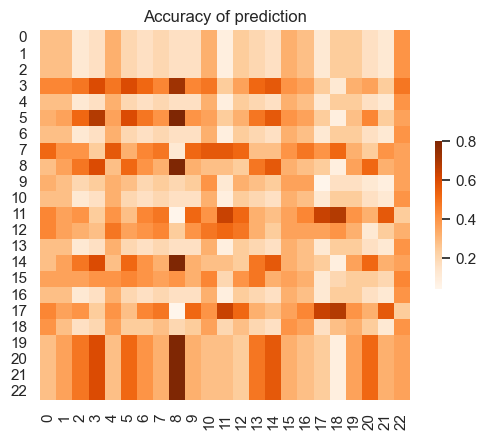

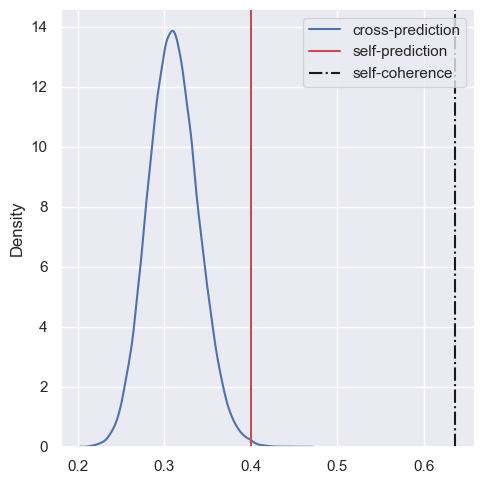

In [190]:
ax = sns.heatmap(acc, 
     cmap="Oranges", 
     square=True, cbar_kws={'shrink': 0.4})
random_data = acc[~np.eye(23, dtype=bool)].reshape(-1,)
plt.title("Accuracy of prediction")
mc_distribution = []
for _ in range(100000):
    mc_distribution.append(np.sum(np.random.choice(random_data, size=23, replace=False))/23)
plt.rc('lines', linewidth=1.5)
# fig, ax = plt.subplots(figsize=(9,7))
sns.displot(data=mc_distribution, kind="kde", label="cross-prediction")
plt.axvline(x=np.mean(np.diag(acc)), linestyle='-', c='r', alpha=1, label='self-prediction') 
# plt.axvline(x=50.72/100, linestyle='-', c='y', alpha=1, label='self-prediction (in repeated trials)')
# plt.axvline(x=np.mean(accuracy_model), linestyle='dotted', c='k', alpha=1, label='vae-predction') 
plt.axvline(x=np.mean(repeat_accuracy_fer), linestyle='dashdot', c='k', alpha=1, label='self-coherence')
plt.legend()

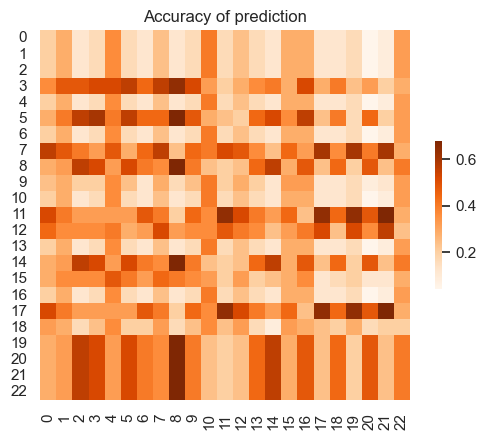

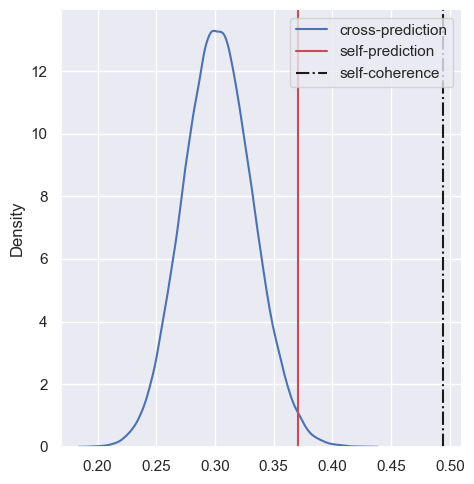

In [191]:
ax = sns.heatmap(acc_repeat, 
     cmap="Oranges", 
     square=True, cbar_kws={'shrink': 0.4})
random_data = acc_repeat[~np.eye(23, dtype=bool)].reshape(-1,)
plt.title("Accuracy of prediction")
mc_distribution = []
for _ in range(100000):
    mc_distribution.append(np.sum(np.random.choice(random_data, size=23, replace=False))/23)
plt.rc('lines', linewidth=1.5)
# fig, ax = plt.subplots(figsize=(9,7))
sns.displot(data=mc_distribution, kind="kde", label="cross-prediction")
plt.axvline(x=np.mean(np.diag(acc_repeat)), linestyle='-', c='r', alpha=1, label='self-prediction') 
# plt.axvline(x=50.72/100, linestyle='-', c='y', alpha=1, label='self-prediction (in repeated trials)')
# plt.axvline(x=np.mean(accuracy_model), linestyle='dotted', c='k', alpha=1, label='vae-predction') 
plt.axvline(x=np.mean(repeat_accuracy_rec), linestyle='dashdot', c='k', alpha=1, label='self-coherence')
plt.legend()

In [140]:
X

array([[ 1.        ,  1.89065408],
       [ 1.        ,  3.34716169],
       [ 1.        ,  1.16510157],
       [ 1.        ,  3.09938951],
       [ 1.        ,  7.5285001 ],
       [ 1.        , 11.23347877],
       [ 1.        ,  3.02165371],
       [ 1.        ,  3.59490474],
       [ 1.        ,  5.05133376],
       [ 1.        ,  4.56013867],
       [ 1.        ,  3.16274279],
       [ 1.        ,  2.32412085],
       [ 1.        ,  2.56801   ],
       [ 1.        ,  2.05457267],
       [ 1.        ,  5.77845075],
       [ 1.        ,  4.86897573],
       [ 1.        ,  3.82642865],
       [ 1.        ,  2.72401239],
       [ 1.        ,  2.27768696],
       [ 1.        ,  5.3398934 ],
       [ 1.        ,  4.44497958],
       [ 1.        ,  1.60051577],
       [ 1.        ,  2.66511976]])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.7179
Date:                Tue, 13 Aug 2024   Prob (F-statistic):              0.406
Time:                        23:13:35   Log-Likelihood:                 13.648
No. Observations:                  23   AIC:                            -23.30
Df Residuals:                      21   BIC:                            -21.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4703      0.048      9.806      0.0

[Text(0, 0.2, '0.2'),
 Text(0, 0.3, '0.3'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.6, '0.6'),
 Text(0, 0.7, '0.7'),
 Text(0, 0.8, '0.8'),
 Text(0, 0.9, '0.9')]

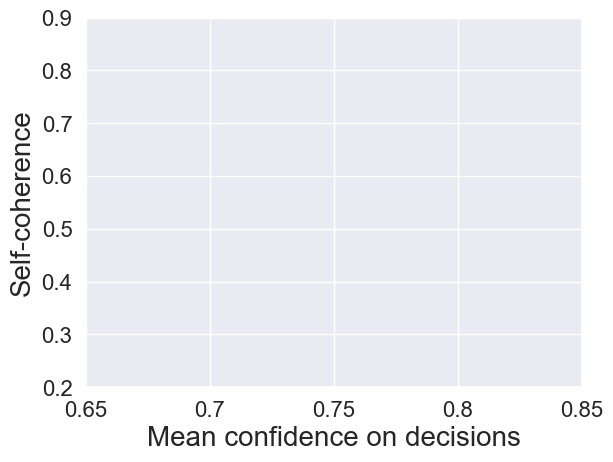

In [17]:
# check if self-coherence could be explained by underlying individuals' representations
y = np.array(repeat_accuracy_rec)
# X = (np.diagonal(np.array(acc))+np.diagonal(np.array(acc_repeat)))/2  # np.array(self_acc)
X = (np.array(confidence_repeat) + np.array(confidence))/2
X = sm.add_constant(X)
linearreg = sm.OLS(y, X).fit()
print(linearreg.summary())

# sns.regplot(x = y, y = np.mean(acc_repeat, axis=0), 
#             scatter_kws = {"color": "red", "alpha": 0.5},
#             line_kws = {"color": "red"})
ax = sns.regplot(x = (np.array(confidence_repeat) + np.array(confidence))/2, y = y, 
            scatter_kws = {"color": "grey", "alpha": 0.5},
            line_kws = {"color": "brown"})
# plt.axis('equal')
plt.xlabel("Mean confidence on decisions", fontdict={'fontsize': 20, 'family':'Arial'})
plt.ylabel("Self-coherence", fontdict={'fontsize': 20, 'family':'Arial'})
plt.xlim(0.65, 0.85)
plt.ylim(0.2, 0.9)  # 40
ax.set(xticks=[0.65, 0.70, 0.75, 0.80, 0.85], yticks=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
ax.set_xticklabels([0.65, 0.70, 0.75, 0.80, 0.85], fontdict={'fontsize': 16, 'family':'Arial'})
ax.set_yticklabels([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontdict={'fontsize': 16, 'family':'Arial'})

(253,)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     14.48
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           0.000178
Time:                        21:09:34   Log-Likelihood:                 193.96
No. Observations:                 253   AIC:                            -383.9
Df Residuals:                     251   BIC:                            -376.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2987      0.035      8.586      0.0

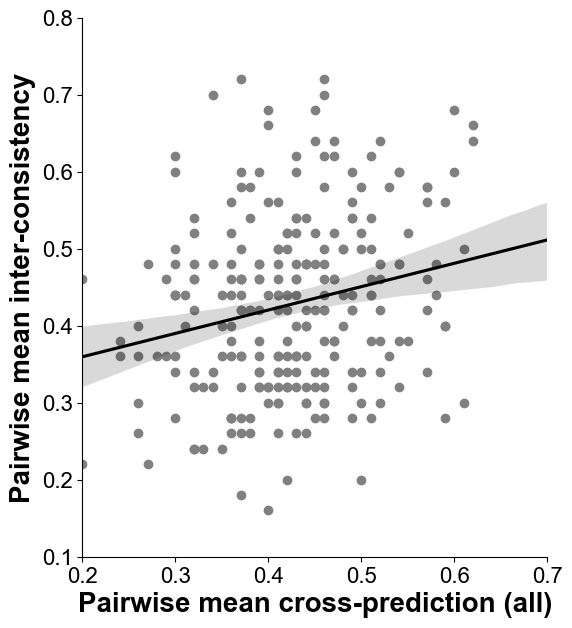

In [146]:
# Correlation between inter-consistency in decision-making and cross-prediction [::-1]
fig, ax = plt.subplots(figsize=(6,7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = sns.regplot(x = (acc_repeat[np.triu_indices(23, 1)]+acc_repeat[np.triu_indices(23, 1)][::-1] + acc[np.triu_indices(23, 1)]+acc[np.triu_indices(23, 1)][::-1])/4, 
            y = (inter_consistency_2[np.triu_indices(23, 1)] + inter_consistency_3[np.triu_indices(23, 1)])/2, 
            scatter_kws = {"color": "grey", "alpha": 1},
            line_kws = {"color": "k"})
# sns.regplot(x = inter_consistency_3[np.triu_indices(23, 1)], y = (acc_repeat[np.triu_indices(23, 1)]+acc_repeat[np.triu_indices(23, 1)][::-1])/2, 
#             scatter_kws = {"color": "red", "alpha": 0.5},
#             line_kws = {"color": "red"})

# ax.set_axis_labels("Pairwise mean cross-prediction", "Pairwise mean inter-consistency", fontdict={'fontsize': 20, 'family':'Arial'})
# plt.title('Distributon of differences between self-prediction and other kinds of prediction', fontdict={'fontsize': 16, 'family':'Arial'})
plt.xlim(0.2, 0.7)
plt.ylim(0.1, 0.8)  # 40
ax.set(xticks=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7], yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_xticklabels([0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontdict={'fontsize': 16, 'family':'Arial'})
ax.set_yticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontdict={'fontsize': 16, 'family':'Arial'})

# plt.title("Correlation between inter-consistency and cross-prediction in repeated test data")
plt.xlabel("Pairwise mean cross-prediction (all)", fontdict={'fontsize': 20, 'family':'Arial', 'weight':'bold'})
plt.ylabel("Pairwise mean inter-consistency", fontdict={'fontsize': 20, 'family':'Arial', 'weight':'bold'})

y = (inter_consistency_2[np.triu_indices(23, 1)] + inter_consistency_3[np.triu_indices(23, 1)])/2
X = (acc_repeat[np.triu_indices(23, 1)]+acc_repeat[np.triu_indices(23, 1)][::-1] + acc[np.triu_indices(23, 1)]+acc[np.triu_indices(23, 1)][::-1])/4  # np.array(self_acc)
X = sm.add_constant(X)
linearreg = sm.OLS(y, X).fit()
print(linearreg.summary())

model's accuracy in testset-repeat: 0.36000000000000004


<Axes: >

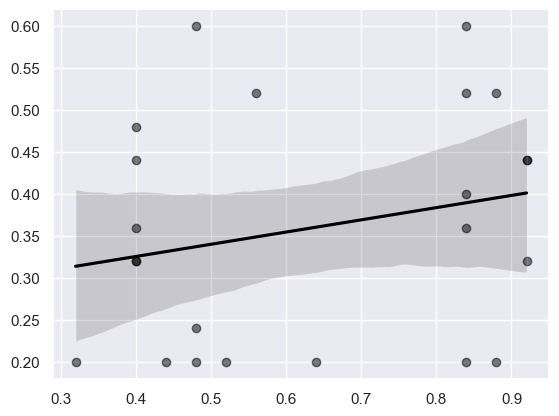

In [195]:
acc_list = []
for i in range(23):
    predict = np.argmin(np.c_[modelset[:, 0] - params[i][0], modelset[:, 1] - params[i][1], modelset[:, 2]], axis=1)
    label = np.argmin(testset_y[:, :, i], axis=1)
    accuracy = np.sum(predict == label)/len(label)
    acc_list.append(accuracy)
print("model's accuracy in testset-repeat:", np.mean(acc_list))
sns.regplot(x = y, y = acc_list, 
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "black"})

In [14]:
# def predict(prior, input):
#     posterior = input - prior
#     return (jnp.max(posterior)-posterior) / (jnp.max(posterior)-jnp.min(posterior))

# batched_predict = vmap(predict, in_axes=(None, 0))

# def one_hot(x, k, dtype=jnp.float32):
#     """Create a one-hot encoding of x of size k."""
#     return jnp.array(x[:, None] == jnp.arange(k), dtype)
    
# def loss(prior, input, targets):
#     preds = batched_predict(prior, input)
#     # targets = one_hot(targets, 3)
#     return jnp.mean((preds - targets)**2)

# def accuracy(prior, input, targets):
#     predicted_class = jnp.argmax(batched_predict(prior, input), axis=1)
#     return jnp.mean(predicted_class == targets)

# @jit
# def update(prior, x, y, step_size):
#     grads = grad(loss)(prior, x, y)
#     # print(grads[0])
#     return jnp.array([prior[0]-step_size*grads[0], prior[1]-step_size*grads[1], 0])

In [15]:
# initilization
# train_performance = []
# test_performance = []
# test_repeat_performance = []
# model_performance = []
# test_matrix = np.zeros((23, 23))
# test_repeat_matrix = np.zeros((23, 23))
# for sub in range(23):
#     p_key = random.key(sub)
#     p = (random.normal(p_key, (3,)) + jnp.array([0, 0, 0])) * jnp.array([1, 1, 0])
#     train_images = individual_train_x[:, :, sub]
#     train_labels = one_hot(individual_train_y[:, 0, sub], 3)*individual_train_y[:, 1, sub].reshape(25, 1)/100
#     test_images, test_labels = testset_x[:, :, sub].numpy(), jnp.argmin(testset_y[:, :, sub].numpy(), axis=1)
#     test_labels_repeat = jnp.argmin(testset_y_repeat[:, :, sub].numpy(), axis=1)
#     step_size = 7
#     for epoch in range(1000):
#         p = update(p, train_images, train_labels, step_size)
#     train_acc = accuracy(p, train_images, jnp.argmax(train_labels, axis=1))
#     test_acc = accuracy(p, test_images, test_labels)
#     test_acc_repeat = accuracy(p, test_images, test_labels_repeat)
#     model_acc = accuracy(p, modelset.numpy(), test_labels)
#     for sub_pred in range(23):
#         test_labels_matrix = jnp.argmin(testset_y[:, :, sub_pred].numpy(), axis=1)
#         test_labels_repeat_matrix = jnp.argmin(testset_y_repeat[:, :, sub_pred].numpy(), axis=1)
#         test_matrix[sub, sub_pred] = accuracy(p, test_images, test_labels_matrix)
#         test_repeat_matrix[sub, sub_pred] = accuracy(p, test_images, test_labels_repeat_matrix)
#     train_performance.append(train_acc)
#     test_performance.append(test_acc_repeat)
#     test_repeat_performance.append(test_acc)
#     model_performance.append(model_acc)
#         # print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
#         # if epoch == 49:
#         #     step_size = 10
#         # if (epoch+1)%100==0:
#         #     print("Training set accuracy {}".format(train_acc))
#         #     print("Test set accuracy {}".format(test_acc))
#         #     print("parameters:", p)
# print(np.mean(train_performance))
# print(np.mean(test_performance))
# print(np.mean(test_repeat_performance))
# print(np.mean(test_matrix))
# print(np.mean(test_repeat_matrix))
# print(np.mean(model_performance))

## TBD